In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.callbacks import ModelCheckpoint

2023-02-19 18:28:09.248067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 18:28:17.765913: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib/python3.8/site-packages:/apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib/python3.8:/apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib:/usr/lib64
2023-02-19 18:28:17.767063: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfe

In [2]:
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        if epoch == 0: self.time = time.monotonic()
            
    def on_epoch_end(self, epoch, logs):
        # calculate training time
        t = time.monotonic() - self.time
        # if validation set is included, its loss is recorded in logs['val_loss']
        print('| Epoch {:4} | training time {:6.2f}s | train loss {:6.2f} |'
              .format(epoch, t, logs['loss']))

def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

In [3]:
df_sales = pd.read_csv("/scratch/gilbreth/vijayarv/sales_train_validation.csv")
df_calender = pd.read_csv("/scratch/gilbreth/vijayarv/calendar.csv")
df_price = pd.read_csv("/scratch/gilbreth/vijayarv/sell_prices.csv")

In [4]:
df_sales

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  \
0         CA_1       CA    0    0    0    0  ...       1       3       0   
1         CA_1       CA    0    0    0    0  ...       0       0       0   
2         CA_1       CA    0    0    0    0  ...       2       1       2   
3         CA_1       CA    0    0    0    0  ...       1       0       5   
4         CA_1       CA    0    0    0    0  ...       2       1       1   
...        ...      ...  ...  ...  ...  ...  ...     ...     ...     ...   
30485     WI_3       WI    0    0    2    2  ...       2       0       0   
30486     WI_3       WI    0    0    0    0  ...       0       0       0   
30487     WI_3       WI    0    6    0    2  ...       2       1       0   
30488     WI_3       WI    0    0    0    0  ...       0       0       1   
30489     WI_3       WI    0    0    0    0  ...       0       0       0   

       d_1907  d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
0           1       1       1       3       0       1       1  
1           0       0       1       0       0       0       0  
2           1       1       1       0       1       1       1  
3           4       1       0       1       3       7       2  
4           0       1       1       2       2       2       4  
...       ...     ...     ...     ...     ...     ...     ...  
30485       0       0       0       1       0       0       1  
30486       0       0       0       0       0       1       0  
30487       2       0       1       0       0       1       0  
30488       0       0       1       0       3       1       3  
30489       0       0       0       0       0       0       0  

[30490 rows x 1919 columns]

# Visualizing time series for a random item in foods 3. 

<AxesSubplot:>

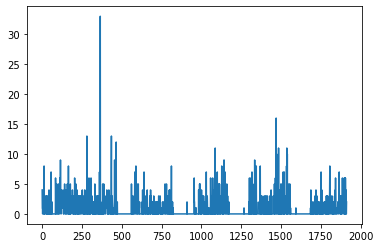

In [6]:
df_ca_foods_1 = df_sales[(df_sales['cat_id']=='FOODS')
                         &(df_sales['dept_id']=='FOODS_1')
                         &(df_sales['store_id']=='CA_1')]

df_ca_s3_foods_3 = df_sales[(df_sales['cat_id']=='FOODS')
                         &(df_sales['dept_id']=='FOODS_3')
                         &(df_sales['store_id']=='CA_3')]

item_3_001 = df_ca_s3_foods_3[df_ca_s3_foods_3['item_id']=='FOODS_3_001'].T.iloc[6:,]

item_3_001.reset_index(inplace=True)

item_3_001[8324].plot()

# The series of the above item alone does shows minimal trend/seasonality. Also, the  spikes and falls are mostly random. So, it would make sense to aggregate all individual items under each food group in each store (foods 1 to foods 3), and model the series of the groups

# Trying for all of foods 1 in the store

In [5]:
foods_1 = df_ca_foods_1.groupby('dept_id').sum().T.reset_index()

foods_1.rename({'index':'d'},axis=1,inplace=True)

df_calender.fillna('nothing',axis=1,inplace=True)

df_calender

foods_1_fm = foods_1.merge(df_calender, on='d').drop(['snap_TX','snap_WI','wday','d'],axis=1)

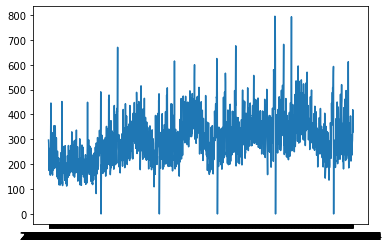

In [5]:
plt.plot(foods_1_fm['date'],foods_1_fm['FOODS_1'])

# Confirming stationarity using the dicky fueller test and visualizing the pacf

/home/vijayarv/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


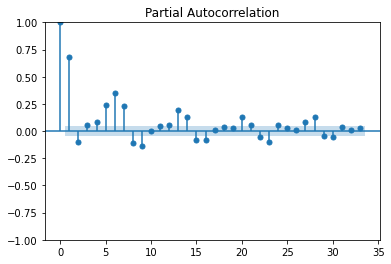

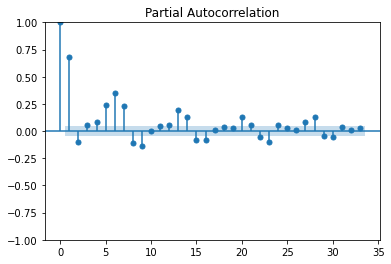

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(foods_1_fm['FOODS_1'])

In [12]:
from statsmodels.tsa.stattools import adfuller
adfuller(foods_1_fm['FOODS_1'])[1]

0.004293354278854139

In [13]:
from pmdarima.arima import auto_arima

In [10]:
for_arima = foods_1_fm[['date','FOODS_1']]
for_arima['date'] = pd.to_datetime(for_arima['date'])
for_arima.set_index('date',inplace=True)

/tmp/ipykernel_108451/3957950523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_arima['date'] = pd.to_datetime(for_arima['date'])


In [11]:
for_arima

FOODS_1
date               
2011-01-29      297
2011-01-30      284
2011-01-31      214
2011-02-01      175
2011-02-02      182
2011-02-03      191
2011-02-04      224
2011-02-05      263
2011-02-06      245
2011-02-07      176
2011-02-08      217
2011-02-09      156
2011-02-10      242
2011-02-11      327
2011-02-12      409
2011-02-13      446
2011-02-14      269
2011-02-15      169
2011-02-16      164
2011-02-17      167
2011-02-18      226
2011-02-19      301
2011-02-20      303
2011-02-21      228
2011-02-22      160
2011-02-23      156
2011-02-24      193
2011-02-25      238
2011-02-26      327
2011-02-27      264
...             ...
2016-03-26      612
2016-03-27      411
2016-03-28      233
2016-03-29      185
2016-03-30      215
2016-03-31      354
2016-04-01      320
2016-04-02      311
2016-04-03      367
2016-04-04      238
2016-04-05      246
2016-04-06      214
2016-04-07      261
2016-04-08      319
2016-04-09      394
2016-04-10      301
2016-04-11      257
2016-04-12      227
2016-04-13      213
2016-04-14      282
2016-04-15      293
2016-04-16      317
2016-04-17      268
2016-04-18      302
2016-04-19      237
2016-04-20      287
2016-04-21      297
2016-04-22      331
2016-04-23      419
2016-04-24      329

[1913 rows x 1 columns]

# It is difficult to manually select p and q, since there are many significant lags. Applying auto-arima

In [16]:
train = for_arima[:1800]
test = for_arima[1800:]
model = auto_arima(train, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2,
                   max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2,
                   max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', 
                   alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, 
                   start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None,
                   seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False,
                   random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0,
                   scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None)

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1800
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -9801.278
Date:                Sat, 04 Feb 2023   AIC                          19624.555
Time:                        22:09:37   BIC                          19685.000
Sample:                    01-29-2011   HQIC                         19646.869
                         - 01-02-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3554      0.027     49.492      0.000       1.302       1.409
ar.L2         -1.8813      0.024    -79.492      0.000      -1.928      -1.835
ar.L3          1.5842      0.039     40.654      0.000       1.508       1.661
ar.L4         -1.4232      0.022    -65.758      0.000      -1.466      -1.381
ar.L5          0.5431      0.025     21.629      0.000       0.494       0.592
ma.L1         -1.7744      0.021    -85.334      0.000      -1.815      -1.734
ma.L2          2.1876      0.034     63.552      0.000       2.120       2.255
ma.L3         -2.1313      0.043    -49.599      0.000      -2.216      -2.047
ma.L4          1.6664      0.035     47.125      0.000       1.597       1.736
ma.L5         -0.8912      0.019    -47.098      0.000      -0.928      -0.854
sigma2      3768.1895     74.640     50.485      0.000    3621.897    3914.482
===================================================================================
Ljung-Box (L1) (Q):                   7.60   Jarque-Bera (JB):             10390.27
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
pred = pd.DataFrame(model.predict(n_periods=113),index=test.index)
pred.columns = ['pred_sales']
pred

pred_sales
date                  
2016-01-03  290.226241
2016-01-04  261.379179
2016-01-05  282.589326
2016-01-06  306.067603
2016-01-07  281.927424
...                ...
2016-04-20  304.330897
2016-04-21  292.556036
2016-04-22  298.351033
2016-04-23  328.024156
2016-04-24  323.591270

[113 rows x 1 columns]

In [19]:
plt.plot(test)
plt.plot(pred)

# SARIMA is unable to capture the variations

# Vanilla Univariate LSTM

In [12]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

In [41]:
split_sequence([1,2,3,4,5,6,7,8,9,10], 3)

(array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7],
        [6, 7, 8],
        [7, 8, 9]]),
 array([ 4,  5,  6,  7,  8,  9, 10]))

In [13]:
for_arima

FOODS_1
date               
2011-01-29      297
2011-01-30      284
2011-01-31      214
2011-02-01      175
2011-02-02      182
...             ...
2016-04-20      287
2016-04-21      297
2016-04-22      331
2016-04-23      419
2016-04-24      329

[1913 rows x 1 columns]

In [14]:
X_train, y_train = split_sequence(list(for_arima[:1800]['FOODS_1']), 5)
X_test, y_test = split_sequence(list(for_arima[1800:]['FOODS_1']), 5)

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

2023-02-08 15:44:28.121665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 15:44:32.757267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib/python3.8/site-packages:/apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib/python3.8:/apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib:/usr/lib64
2023-02-08 15:44:32.760695: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfe

In [9]:
from tensorflow.keras.layers import LSTM

In [41]:
model = tf.keras.Sequential()
model.add(LSTM(50, activation='relu', input_shape=(5, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

In [44]:
import time

In [44]:
X_train

array([[[297],
        [284],
        [214],
        [175],
        [182]],

       [[284],
        [214],
        [175],
        [182],
        [191]],

       [[214],
        [175],
        [182],
        [191],
        [224]],

       ...,

       [[274],
        [250],
        [200],
        [275],
        [237]],

       [[250],
        [200],
        [275],
        [237],
        [245]],

       [[200],
        [275],
        [237],
        [245],
        [250]]])

In [10]:
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        if epoch == 0: self.time = time.monotonic()
            
    def on_epoch_end(self, epoch, logs):
        # calculate training time
        t = time.monotonic() - self.time
        # if validation set is included, its loss is recorded in logs['val_loss']
        print('| Epoch {:4} | training time {:6.2f}s | train loss {:6.2f} |'
              .format(epoch, t, logs['loss']))

In [45]:
model.fit(X_train, y_train, epochs=1000,callbacks=[PrintLoss()])

Epoch 1/1000
57/57 [==============================] - 1s 3ms/step - loss: 19054.8008
Epoch 2/1000
57/57 [==============================] - 0s 3ms/step - loss: 5262.8711
Epoch 3/1000
57/57 [==============================] - 0s 2ms/step - loss: 5155.4116
Epoch 4/1000
57/57 [==============================] - 0s 2ms/step - loss: 4885.1353
Epoch 5/1000
57/57 [==============================] - 0s 2ms/step - loss: 5311.4414
Epoch 6/1000
57/57 [==============================] - 0s 2ms/step - loss: 4800.2476
Epoch 7/1000
57/57 [==============================] - 0s 2ms/step - loss: 4716.8276
Epoch 8/1000
57/57 [==============================] - 0s 2ms/step - loss: 4674.4971
Epoch 9/1000
57/57 [==============================] - 0s 2ms/step - loss: 4877.1460
Epoch 10/1000
57/57 [==============================] - 0s 2ms/step - loss: 4845.6250
Epoch 11/1000
57/57 [==============================] - 0s 2ms/step - loss: 5012.9019
Epoch 12/1000
57/57 [==============================] - 0s 2ms/step - loss

In [46]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)

4/4 [==============================] - 0s 1ms/step


In [10]:
from sklearn.metrics import mean_absolute_percentage_error as mape

In [48]:
mape(y_test, y_test_pred)

0.16167876216782934

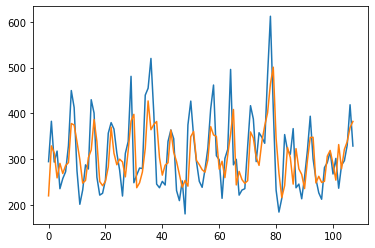

In [49]:
plt.plot(y_test)
plt.plot(y_test_pred)

# Increasing the number of lags

In [50]:
X_train, y_train = split_sequence(list(for_arima[:1800]['FOODS_1']), 20)
X_test, y_test = split_sequence(list(for_arima[1800:]['FOODS_1']), 20)

In [51]:
model = tf.keras.Sequential()
model.add(LSTM(50, activation='relu', input_shape=(20, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [52]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

In [53]:
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        if epoch == 0: self.time = time.monotonic()
            
    def on_epoch_end(self, epoch, logs):
        # calculate training time
        t = time.monotonic() - self.time
        # if validation set is included, its loss is recorded in logs['val_loss']
        print('| Epoch {:4} | training time {:6.2f}s | train loss {:6.2f} |'
              .format(epoch, t, logs['loss']))


model.fit(X_train, y_train, epochs=1000,callbacks=[PrintLoss()])

Epoch 1/1000
56/56 [==============================] - 1s 7ms/step - loss: 21749.9688
Epoch 2/1000
56/56 [==============================] - 0s 7ms/step - loss: 5240.0454
Epoch 3/1000
56/56 [==============================] - 0s 7ms/step - loss: 4567.2617
Epoch 4/1000
56/56 [==============================] - 0s 7ms/step - loss: 4515.5063
Epoch 5/1000
56/56 [==============================] - 0s 7ms/step - loss: 4414.1714
Epoch 6/1000
56/56 [==============================] - 0s 7ms/step - loss: 4732.3198
Epoch 7/1000
56/56 [==============================] - 0s 7ms/step - loss: 5296.6704
Epoch 8/1000
56/56 [==============================] - 0s 7ms/step - loss: 4951.6377
Epoch 9/1000
56/56 [==============================] - 0s 7ms/step - loss: 4566.9736
Epoch 10/1000
56/56 [==============================] - 0s 7ms/step - loss: 4653.4243
Epoch 11/1000
56/56 [==============================] - 0s 7ms/step - loss: 4497.1802
Epoch 12/1000
56/56 [==============================] - 0s 7ms/step - loss

In [54]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)
mape(y_test, y_test_pred)

3/3 [==============================] - 0s 3ms/step


0.14788742448979883

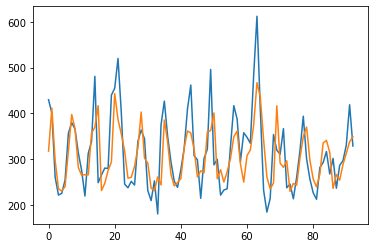

In [55]:
plt.plot(y_test)
plt.plot(y_test_pred)

# Increasing number of features

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [38]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
filepath="weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs=500,callbacks=[checkpoint])

Epoch 1/500
53/56 [===========================>..] - ETA: 0s - loss: 8443.3535
Epoch 1: loss improved from inf to 8746.99219, saving model to weights-improvement-01-8746.99.hdf5
56/56 [==============================] - 1s 14ms/step - loss: 8746.9922
Epoch 2/500
53/56 [===========================>..] - ETA: 0s - loss: 8593.1123
Epoch 2: loss improved from 8746.99219 to 8483.91309, saving model to weights-improvement-02-8483.91.hdf5
56/56 [==============================] - 1s 14ms/step - loss: 8483.9131
Epoch 3/500
53/56 [===========================>..] - ETA: 0s - loss: 8538.3594
Epoch 3: loss did not improve from 8483.91309
56/56 [==============================] - 1s 14ms/step - loss: 8530.4619
Epoch 4/500
53/56 [===========================>..] - ETA: 0s - loss: 8656.4912
Epoch 4: loss did not improve from 8483.91309
56/56 [==============================] - 1s 14ms/step - loss: 8583.1826
Epoch 5/500
53/56 [===========================>..] - ETA: 0s - loss: 8380.1836
Epoch 5: loss improv

In [61]:
model.load_weights("weights-improvement-432-3298.95.hdf5")

In [62]:
model.compile(optimizer='adam', loss='mse')

In [63]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)

3/3 [==============================] - 0s 6ms/step


In [64]:
y_test_pred_1 = [i[0] for i in y_test_pred]
y_test_pred_2 = [i[1] for i in y_test_pred]

In [65]:
mape(y_test, y_test_pred_1)

0.1447137281597536

In [66]:
mape(y_test, y_test_pred_2)

0.1417472259299576

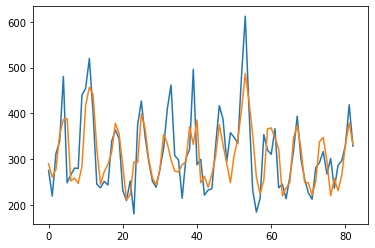

In [68]:
plt.plot(y_test)
plt.plot(y_test_pred_2)

# Using some more lags

In [21]:
foods_1_fm['event_1'] = foods_1_fm['event_name_1']+foods_1_fm['event_type_1']
foods_1_fm['event_2'] = foods_1_fm['event_name_2']+foods_1_fm['event_type_2']

foods_1_fm.drop(['event_name_1','event_type_1','event_name_2','event_type_2','wm_yr_wk'],axis=1,inplace=True)

foods_1_fm = pd.concat([foods_1_fm,pd.get_dummies(foods_1_fm[['weekday','month','event_1','event_2']],drop_first=True)],axis=1)

foods_1_fm.drop(['weekday','month','event_1','event_2','year'],axis=1,inplace=True)

foods_1_fm.set_index('date',inplace=True)

In [26]:
foods_1_fm

FOODS_1  snap_CA  weekday_Monday  weekday_Saturday  \
date                                                             
2011-01-29      297        0               0                 1   
2011-01-30      284        0               0                 0   
2011-01-31      214        0               1                 0   
2011-02-01      175        1               0                 0   
2011-02-02      182        1               0                 0   
...             ...      ...             ...               ...   
2016-04-20      287        0               0                 0   
2016-04-21      297        0               0                 0   
2016-04-22      331        0               0                 0   
2016-04-23      419        0               0                 1   
2016-04-24      329        0               0                 0   

            weekday_Sunday  weekday_Thursday  weekday_Tuesday  \
date                                                            
2011-01-29               0                 0                0   
2011-01-30               1                 0                0   
2011-01-31               0                 0                0   
2011-02-01               0                 0                1   
2011-02-02               0                 0                0   
...                    ...               ...              ...   
2016-04-20               0                 0                0   
2016-04-21               0                 1                0   
2016-04-22               0                 0                0   
2016-04-23               0                 0                0   
2016-04-24               1                 0                0   

            weekday_Wednesday  event_1_ChristmasNational  \
date                                                       
2011-01-29                  0                          0   
2011-01-30                  0                          0   
2011-01-31                  0                          0   
2011-02-01                  0                          0   
2011-02-02                  1                          0   
...                       ...                        ...   
2016-04-20                  1                          0   
2016-04-21                  0                          0   
2016-04-22                  0                          0   
2016-04-23                  0                          0   
2016-04-24                  0                          0   

            event_1_Cinco De MayoCultural  ...  event_1_StPatricksDayCultural  \
date                                       ...                                  
2011-01-29                              0  ...                              0   
2011-01-30                              0  ...                              0   
2011-01-31                              0  ...                              0   
2011-02-01                              0  ...                              0   
2011-02-02                              0  ...                              0   
...                                   ...  ...                            ...   
2016-04-20                              0  ...                              0   
2016-04-21                              0  ...                              0   
2016-04-22                              0  ...                              0   
2016-04-23                              0  ...                              0   
2016-04-24                              0  ...                              0   

            event_1_SuperBowlSporting  event_1_ThanksgivingNational  \
date                                                                  
2011-01-29                          0                             0   
2011-01-30                          0                             0   
2011-01-31                          0                             0   
2011-02-01                          0                             0   
2011-02-02                          0         

In [19]:
len(foods_1_fm['FOODS_1'][30:1800])

1770

In [22]:
X_train_f1, y_train = split_sequence(list(foods_1_fm[:1800]['FOODS_1']), 30)
X_test_f1, y_test = split_sequence(list(foods_1_fm[1800:]['FOODS_1']), 30)

In [23]:
X_train = (X_train_f1)
X_test = (X_test_f1)

In [24]:
oth_train = (foods_1_fm.iloc[30:1800,1:].values)
oth_test = (foods_1_fm.iloc[1830:,1:].values)

In [25]:
o_train=[]
o_test=[]
for i in oth_train:
    o_train.append(i)
for i in oth_test:
    o_test.append(i)   

In [26]:
np.append(X_train[0],o_train[0])

array([297, 284, 214, 175, 182, 191, 224, 263, 245, 176, 217, 156, 242,
       327, 409, 446, 269, 169, 164, 167, 226, 301, 303, 228, 160, 156,
       193, 238, 327, 264,   0,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   1,   0,   0,   0,   1])

In [27]:
l_train=[]
l_test=[]
for i in range(len(o_train)):
    l_train.append(np.append(X_train[i],o_train[i]))
for i in range(len(o_test)):
    l_test.append(np.append(X_test[i],o_test[i]))

In [28]:
X_train = np.array(l_train)
X_test = np.array(l_test)

In [29]:
X_train.shape

(1770, 71)

In [81]:
model = tf.keras.Sequential()
model.add(LSTM(10, activation='relu', input_shape=(71, 1)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
filepath="weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train, epochs=500,callbacks=[checkpoint])

Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 96165.2969
Epoch 1: loss improved from inf to 96263.26562, saving model to weights-improvement-01-96263.27.hdf5
56/56 [==============================] - 3s 29ms/step - loss: 96263.2656
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 38490.1719
Epoch 2: loss improved from 96263.26562 to 38340.96094, saving model to weights-improvement-02-38340.96.hdf5
56/56 [==============================] - 2s 29ms/step - loss: 38340.9609
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 28054.1660
Epoch 3: loss improved from 38340.96094 to 28041.42383, saving model to weights-improvement-03-28041.42.hdf5
56/56 [==============================] - 2s 29ms/step - loss: 28041.4238
Epoch 4/500
55/56 [============================>.] - ETA: 0s - loss: 18263.9141
Epoch 4: loss improved from 28041.42383 to 18204.92188, saving model to weights-improvement-04-18204.92.hdf5
56/56 [==========================

In [82]:
model.load_weights("weights-improvement-113-4142.42.hdf5")
model.compile(optimizer='adam', loss='mse')
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)
y_test_pred_1 = [i[0] for i in y_test_pred]
y_test_pred_2 = [i[1] for i in y_test_pred]

3/3 [==============================] - 0s 8ms/step


In [83]:
mape(y_test, y_test_pred_1)

0.18904552214516276

In [84]:
mape(y_test, y_test_pred_2)

0.18820919267464323

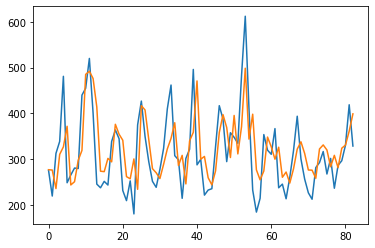

In [85]:
plt.plot(y_test)
plt.plot(y_test_pred_2)

# Trying a different activation function and optimizer

In [12]:
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

In [33]:
model = tf.keras.Sequential()
model.add(LSTM(10, activation=mish, input_shape=(71, 1)))
model.add(Dense(1))
model.compile(optimizer='RMSprop', loss='mse')
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
filepath="weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train, epochs=500,callbacks=[checkpoint],batch_size=5)

Epoch 1/500
354/354 [==============================] - ETA: 0s - loss: 21150.2012
Epoch 1: loss improved from inf to 21150.20117, saving model to weights-improvement-01-21150.20.hdf5
354/354 [==============================] - 9s 20ms/step - loss: 21150.2012
Epoch 2/500
352/354 [============================>.] - ETA: 0s - loss: 8301.7129
Epoch 2: loss improved from 21150.20117 to 8266.27637, saving model to weights-improvement-02-8266.28.hdf5
354/354 [==============================] - 7s 19ms/step - loss: 8266.2764
Epoch 3/500
352/354 [============================>.] - ETA: 0s - loss: 9656.9160
Epoch 3: loss did not improve from 8266.27637
354/354 [==============================] - 7s 20ms/step - loss: 9610.6738
Epoch 4/500
352/354 [============================>.] - ETA: 0s - loss: 47566.9531
Epoch 4: loss did not improve from 8266.27637
354/354 [==============================] - 7s 20ms/step - loss: 47484.5117
Epoch 5/500
351/354 [============================>.] - ETA: 0s - loss: 31326

In [52]:
model.load_weights("weights-improvement-369-3632.08.hdf5")
model.compile(optimizer='adam', loss='mse')
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)
y_test_pred_1 = [i[0] for i in y_test_pred]

3/3 [==============================] - 0s 9ms/step


In [53]:
mape(y_test, y_test_pred_1)

0.14851007587096424

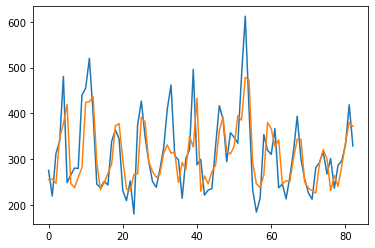

In [54]:
plt.plot(y_test)
plt.plot(y_test_pred_1)

In [57]:
model.load_weights("weights-improvement-279-3842.74.hdf5")
model.compile(optimizer='adam', loss='mse')
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)
y_test_pred_1 = [i[0] for i in y_test_pred]
plt.plot(y_test)
plt.plot(y_test_pred_1)

3/3 [==============================] - 0s 9ms/step


In [58]:
mape(y_test, y_test_pred_1)

0.2030257157488691

In [59]:
model.load_weights("weights-improvement-369-3632.08.hdf5")
model.compile(optimizer='adam', loss='mse')
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)
y_test_pred_p1 = [i[0] for i in y_test_pred]

3/3 [==============================] - 0s 9ms/step


In [60]:
model.load_weights("weights-improvement-279-3842.74.hdf5")
model.compile(optimizer='adam', loss='mse')
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)
y_test_pred_2 = [i[0] for i in y_test_pred]

3/3 [==============================] - 0s 8ms/step


In [62]:
df_comp = pd.DataFrame()
df_comp['model_1'] = y_test_pred_p1
df_comp['model_2'] = y_test_pred_2

In [17]:
def which(x,y):
    if x<300:
        return x
    elif y>400:
        return y
    else:
        return x
    

In [67]:
df_comp['col_3'] = df_comp.apply(lambda x: which(x.model_1, x.model_2), axis=1)

In [69]:
mape(y_test, df_comp['col_3'])

0.1554347928408044

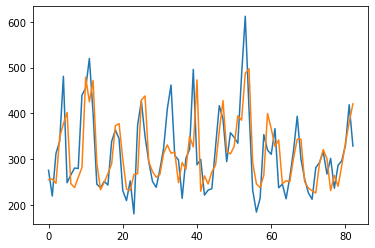

In [70]:
plt.plot(y_test)
plt.plot(df_comp['col_3'])

In [71]:
X_train

array([[[297],
        [284],
        [214],
        ...,
        [  0],
        [  0],
        [  1]],

       [[284],
        [214],
        [175],
        ...,
        [  0],
        [  0],
        [  1]],

       [[214],
        [175],
        [182],
        ...,
        [  0],
        [  0],
        [  1]],

       ...,

       [[264],
        [256],
        [282],
        ...,
        [  0],
        [  0],
        [  1]],

       [[256],
        [282],
        [253],
        ...,
        [  0],
        [  0],
        [  1]],

       [[282],
        [253],
        [367],
        ...,
        [  0],
        [  0],
        [  1]]])

In [ ]:
model = tf.keras.Sequential()
model.add(LSTM(100, activation='relu', input_shape=(71, 1)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
filepath="model-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train, epochs=250,callbacks=[checkpoint],batch_size=5)

Epoch 1/250
353/354 [============================>.] - ETA: 0s - loss: 16.9656
Epoch 1: loss improved from inf to 16.93959, saving model to model-01-16.94.hdf5
354/354 [==============================] - 13s 33ms/step - loss: 16.9396
Epoch 2/250
353/354 [============================>.] - ETA: 0s - loss: 28.2704
Epoch 2: loss did not improve from 16.93959
354/354 [==============================] - 12s 34ms/step - loss: 28.2825
Epoch 3/250
353/354 [============================>.] - ETA: 0s - loss: 31.1864
Epoch 3: loss did not improve from 16.93959
354/354 [==============================] - 12s 33ms/step - loss: 31.1670
Epoch 4/250
353/354 [============================>.] - ETA: 0s - loss: 31.4529
Epoch 4: loss did not improve from 16.93959
354/354 [==============================] - 12s 33ms/step - loss: 31.4577
Epoch 5/250
353/354 [============================>.] - ETA: 0s - loss: 31.9069
Epoch 5: loss did not improve from 16.93959
354/354 [==============================] - 11s 32ms/step

In [33]:
model = tf.keras.Sequential()
model.add(LSTM(10, activation=mish, input_shape=(71, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train, epochs=500,callbacks=[checkpoint],batch_size=5,validation_split=0.2)

Epoch 1/500
283/284 [============================>.] - ETA: 0s - loss: 38666.6445
Epoch 1: val_loss improved from inf to 18525.76758, saving model to weights-improvement-01-18525.77.hdf5
284/284 [==============================] - 12s 36ms/step - loss: 38663.5859 - val_loss: 18525.7676
Epoch 2/500
283/284 [============================>.] - ETA: 0s - loss: 11041.8242
Epoch 2: val_loss improved from 18525.76758 to 10927.31543, saving model to weights-improvement-02-10927.32.hdf5
284/284 [==============================] - 10s 35ms/step - loss: 11037.5010 - val_loss: 10927.3154
Epoch 3/500
283/284 [============================>.] - ETA: 0s - loss: 9622.6836
Epoch 3: val_loss did not improve from 10927.31543
284/284 [==============================] - 10s 35ms/step - loss: 9622.5195 - val_loss: 15985.4561
Epoch 4/500
283/284 [============================>.] - ETA: 0s - loss: 9285.4258
Epoch 4: val_loss did not improve from 10927.31543
284/284 [==============================] - 10s 35ms/step -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



283/284 [============================>.] - ETA: 0s - loss: 6742.4893
Epoch 385: val_loss did not improve from 5633.61621
284/284 [==============================] - 9s 31ms/step - loss: 6737.9365 - val_loss: 13177.0879
Epoch 386/500
283/284 [============================>.] - ETA: 0s - loss: 6735.7207
Epoch 386: val_loss did not improve from 5633.61621
284/284 [==============================] - 9s 30ms/step - loss: 6732.7861 - val_loss: 10916.9727
Epoch 387/500
283/284 [============================>.] - ETA: 0s - loss: 6713.4966
Epoch 387: val_loss did not improve from 5633.61621
284/284 [==============================] - 9s 30ms/step - loss: 6714.1626 - val_loss: 8384.0547
Epoch 388/500
283/284 [============================>.] - ETA: 0s - loss: 6795.4629
Epoch 388: val_loss did not improve from 5633.61621
284/284 [==============================] - 9s 30ms/step - loss: 6790.9917 - val_loss: 12818.2344
Epoch 389/500
283/284 [============================>.] - ETA: 0s - loss: 6696.6777
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



283/284 [============================>.] - ETA: 0s - loss: 6565.9727
Epoch 426: val_loss did not improve from 5633.61621
284/284 [==============================] - 10s 35ms/step - loss: 6562.7549 - val_loss: 9439.9912
Epoch 427/500
283/284 [============================>.] - ETA: 0s - loss: 6579.7144
Epoch 427: val_loss did not improve from 5633.61621
284/284 [==============================] - 10s 35ms/step - loss: 6577.5161 - val_loss: 11358.4619
Epoch 428/500
283/284 [============================>.] - ETA: 0s - loss: 6588.4438
Epoch 428: val_loss did not improve from 5633.61621
284/284 [==============================] - 10s 35ms/step - loss: 6586.3530 - val_loss: 9847.1221
Epoch 429/500
283/284 [============================>.] - ETA: 0s - loss: 6402.6040
Epoch 429: val_loss did not improve from 5633.61621
284/284 [==============================] - 10s 35ms/step - loss: 6402.6899 - val_loss: 11052.3457
Epoch 430/500
283/284 [============================>.] - ETA: 0s - loss: 6453.0947
E

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



283/284 [============================>.] - ETA: 0s - loss: 6321.8115
Epoch 469: val_loss did not improve from 5633.61621
284/284 [==============================] - 9s 31ms/step - loss: 6326.7148 - val_loss: 8916.2881
Epoch 470/500
283/284 [============================>.] - ETA: 0s - loss: 6259.5454
Epoch 470: val_loss did not improve from 5633.61621
284/284 [==============================] - 9s 30ms/step - loss: 6261.0249 - val_loss: 8977.2490
Epoch 471/500
283/284 [============================>.] - ETA: 0s - loss: 5670.0977
Epoch 471: val_loss did not improve from 5633.61621
284/284 [==============================] - 9s 30ms/step - loss: 5667.6816 - val_loss: 7106.5620
Epoch 472/500
283/284 [============================>.] - ETA: 0s - loss: 5341.6362
Epoch 472: val_loss did not improve from 5633.61621
284/284 [==============================] - 9s 30ms/step - loss: 5350.5078 - val_loss: 8845.3271
Epoch 473/500
283/284 [============================>.] - ETA: 0s - loss: 5552.1533
Epoch 4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [34]:
model.load_weights("weights-improvement-169-5633.62.hdf5")
model.compile(optimizer='adam', loss='mse')
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)
y_test_pred_p1 = [i[0] for i in y_test_pred]

3/3 [==============================] - 0s 8ms/step


In [37]:
mape(y_test, y_test_pred_p1)

0.1807037476797992

In [38]:
plt.plot(y_test)
plt.plot(y_test_pred_p1)

In [18]:
foods_1_fm_cnn = foods_1_fm[30:].reset_index()

for_cnn_time = pd.DataFrame(split_sequence(foods_1_fm['FOODS_1'],30)[0])

for_cnn_time['date'] = foods_1_fm_cnn['date']

for_cnn_foods_1_fm = foods_1_fm_cnn.merge(for_cnn_time,on='date').set_index('date')

In [19]:
for_cnn_foods_1_fm

index  FOODS_1  wm_yr_wk    weekday  month  year event_name_1  \
date                                                                        
2011-02-28     30      177     11105     Monday      2  2011      nothing   
2011-03-01     31      276     11105    Tuesday      3  2011      nothing   
2011-03-02     32      203     11105  Wednesday      3  2011      nothing   
2011-03-03     33      216     11105   Thursday      3  2011      nothing   
2011-03-04     34      230     11105     Friday      3  2011      nothing   
...           ...      ...       ...        ...    ...   ...          ...   
2016-04-20   1908      287     11612  Wednesday      4  2016      nothing   
2016-04-21   1909      297     11612   Thursday      4  2016      nothing   
2016-04-22   1910      331     11612     Friday      4  2016      nothing   
2016-04-23   1911      419     11613   Saturday      4  2016      nothing   
2016-04-24   1912      329     11613     Sunday      4  2016      nothing   

           event_type_1 event_name_2 event_type_2  ...   20   21   22   23  \
date                                               ...                       
2011-02-28      nothing      nothing      nothing  ...  226  301  303  228   
2011-03-01      nothing      nothing      nothing  ...  301  303  228  160   
2011-03-02      nothing      nothing      nothing  ...  303  228  160  156   
2011-03-03      nothing      nothing      nothing  ...  228  160  156  193   
2011-03-04      nothing      nothing      nothing  ...  160  156  193  238   
...                 ...          ...          ...  ...  ...  ...  ...  ...   
2016-04-20      nothing      nothing      nothing  ...  301  257  227  213   
2016-04-21      nothing      nothing      nothing  ...  257  227  213  282   
2016-04-22      nothing      nothing      nothing  ...  227  213  282  293   
2016-04-23      nothing      nothing      nothing  ...  213  282  293  317   
2016-04-24      nothing      nothing      nothing  ...  282  293  317  268   

             24   25   26   27   28   29  
date                                      
2011-02-28  160  156  193  238  327  264  
2011-03-01  156  193  238  327  264  177  
2011-03-02  193  238  327  264  177  276  
2011-03-03  238  327  264  177  276  203  
2011-03-04  327  264  177  276  203  216  
...         ...  ...  ...  ...  ...  ...  
2016-04-20  282  293  317  268  302  237  
2016-04-21  293  317  268  302  237  287  
2016-04-22  317  268  302  237  287  297  
2016-04-23  268  302  237  287  297  331  
2016-04-24  302  237  287  297  331  419  

[1883 rows x 41 columns]

In [42]:
X_train = for_cnn_foods_1_fm.iloc[:1800,1:]
y_train = for_cnn_foods_1_fm.iloc[:1800,0]
X_test = for_cnn_foods_1_fm.iloc[1800:,1:]
y_test = for_cnn_foods_1_fm.iloc[1800:,0]

In [43]:
X_train

snap_CA  weekday_Monday  weekday_Saturday  weekday_Sunday  \
date                                                                    
2011-02-28        0               1                 0               0   
2011-03-01        1               0                 0               0   
2011-03-02        1               0                 0               0   
2011-03-03        1               0                 0               0   
2011-03-04        1               0                 0               0   
...             ...             ...               ...             ...   
2016-01-28        0               0                 0               0   
2016-01-29        0               0                 0               0   
2016-01-30        0               0                 1               0   
2016-01-31        0               0                 0               1   
2016-02-01        1               1                 0               0   

            weekday_Thursday  weekday_Tuesday  weekday_Wednesday  \
date                                                               
2011-02-28                 0                0                  0   
2011-03-01                 0                1                  0   
2011-03-02                 0                0                  1   
2011-03-03                 1                0                  0   
2011-03-04                 0                0                  0   
...                      ...              ...                ...   
2016-01-28                 1                0                  0   
2016-01-29                 0                0                  0   
2016-01-30                 0                0                  0   
2016-01-31                 0                0                  0   
2016-02-01                 0                0                  0   

            event_1_ChristmasNational  event_1_Cinco De MayoCultural  \
date                                                                   
2011-02-28                          0                              0   
2011-03-01                          0                              0   
2011-03-02                          0                              0   
2011-03-03                          0                              0   
2011-03-04                          0                              0   
...                               ...                            ...   
2016-01-28                          0                              0   
2016-01-29                          0                              0   
2016-01-30                          0                              0   
2016-01-31                          0                              0   
2016-02-01                          0                              0   

            event_1_ColumbusDayNational  ...   20   21   22   23   24   25  \
date                                     ...                                 
2011-02-28                            0  ...  226  301  303  228  160  156   
2011-03-01                            0  ...  301  303  228  160  156  193   
2011-03-02                            0  ...  303  228  160  156  193  238   
2011-03-03                            0  ...  228  160  156  193  238  327   
2011-03-04                            0  ...  160  156  193  238  327  264   
...                                 ...  ...  ...  ...  ...  ...  ...  ...   
2016-01-28                            0  ...  275  202  233  288  279  430   
2016-01-29                            0  ...  202  233  288  279  430  401   
2016-01-30                            0  ...  233  288  279  430  401  261   
2016-01-31                            0  ...  288  279  430  401  261  222   
2016-02-01                            0  ...  279  430  401  261  222  226   

             26   27   28   29  
date                            
2011-02-28  193  238  327  264  
2011-03-01  238  327  264  177  
2011-03-02  327  264  177  276  
2011-03-03  264  177  276  203  
2011-03-04  177  276  203  

In [45]:
np.array(X_train).shape

(1800, 71)

In [9]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

# Trying a multivariate CNN - different from an LSTM in the sense that it does not store information of previous lags. However, we can add more information about a given day - day of the week, event day etc.

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [14]:
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

def build_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(71, )))
    model.add(Dense(32, activation=mish))
    model.add(Dense(64, activation=mish))
    model.add(Dense(128, activation=mish))
    model.add(Dense(256, activation=mish))
    model.add(Dense(512, activation=mish))
    model.add(Dense(1024, activation=mish))
    model.add(Dense(2048, activation=mish))
    model.add(Dense(2, activation='linear'))
    return model

In [48]:
model = build_model()

2023-02-06 22:27:45.450180: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib/python3.8/site-packages:/apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib/python3.8:/apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib:/usr/lib64
2023-02-06 22:27:45.450266: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-06 22:27:45.451023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow b

In [49]:
model.compile(optimizer='adam',
                  loss='mse')

In [50]:
history = model.fit(X_train, y_train,
                    batch_size=256, epochs=100)

Epoch 1/100
8/8 [==============================] - 3s 85ms/step - loss: 30493.2363
Epoch 2/100
8/8 [==============================] - 1s 81ms/step - loss: 10539.7920
Epoch 3/100
8/8 [==============================] - 1s 86ms/step - loss: 6709.3726
Epoch 4/100
8/8 [==============================] - 1s 85ms/step - loss: 5245.6948
Epoch 5/100
8/8 [==============================] - 1s 78ms/step - loss: 5319.1118
Epoch 6/100
8/8 [==============================] - 1s 77ms/step - loss: 4366.3535
Epoch 7/100
8/8 [==============================] - 1s 80ms/step - loss: 4004.7554
Epoch 8/100
8/8 [==============================] - 1s 83ms/step - loss: 3807.7395
Epoch 9/100
8/8 [==============================] - 1s 82ms/step - loss: 7098.7935
Epoch 10/100
8/8 [==============================] - 1s 79ms/step - loss: 5193.4863
Epoch 11/100
8/8 [==============================] - 1s 79ms/step - loss: 4887.6772
Epoch 12/100
8/8 [==============================] - 1s 79ms/step - loss: 4012.0083
Epoch 13/10

In [57]:
X_test = np.array(X_test)
y_test_pred = model.predict(X_test)

3/3 [==============================] - 0s 7ms/step


In [58]:
y_test_pred = [i[0] for i in y_test_pred]

In [59]:
mape(y_test,y_test_pred)

0.17468749842659764

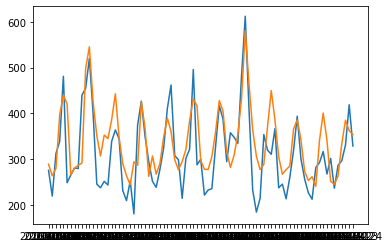

In [60]:
plt.plot(y_test)
plt.plot(y_test_pred)

In [63]:
filepath="cnn-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train,
                    batch_size=10, epochs=200,validation_split=0.1,callbacks=[checkpoint])

Epoch 1/200
161/162 [============================>.] - ETA: 0s - loss: 3328.9954
Epoch 1: val_loss improved from inf to 4887.36035, saving model to cnn-01-4887.36.hdf5
162/162 [==============================] - 8s 50ms/step - loss: 3330.0254 - val_loss: 4887.3604
Epoch 2/200
162/162 [==============================] - ETA: 0s - loss: 3668.0422
Epoch 2: val_loss did not improve from 4887.36035
162/162 [==============================] - 8s 48ms/step - loss: 3668.0422 - val_loss: 8815.6641
Epoch 3/200
162/162 [==============================] - ETA: 0s - loss: 3695.2114
Epoch 3: val_loss improved from 4887.36035 to 4472.84912, saving model to cnn-03-4472.85.hdf5
162/162 [==============================] - 8s 50ms/step - loss: 3695.2114 - val_loss: 4472.8491
Epoch 4/200
161/162 [============================>.] - ETA: 0s - loss: 3365.7227
Epoch 4: val_loss did not improve from 4472.84912
162/162 [==============================] - 8s 50ms/step - loss: 3368.2161 - val_loss: 4641.2349
Epoch 5/200

In [64]:
model.load_weights("cnn-167-4008.38.hdf5")
model.compile(optimizer='adam', loss='mse')
X_test = np.array(X_test)
y_test_pred= model.predict(X_test)
y_test_pred = [i[0] for i in y_test_pred]

3/3 [==============================] - 0s 10ms/step


In [65]:
mape(y_test,y_test_pred)

0.13935790900361686

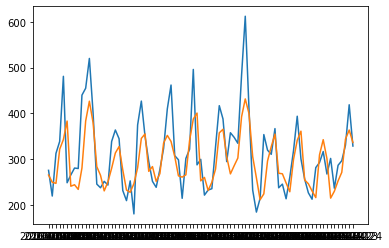

In [66]:
plt.plot(y_test)
plt.plot(y_test_pred)

In [67]:
filepath="cnn-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train,
                    batch_size=100, epochs=300,validation_split=0.1,callbacks=[checkpoint])

Epoch 1/300
17/17 [==============================] - ETA: 0s - loss: 2528.1946
Epoch 1: val_loss improved from inf to 4707.07861, saving model to cnn-01-4707.08.hdf5
17/17 [==============================] - 4s 110ms/step - loss: 2528.1946 - val_loss: 4707.0786
Epoch 2/300
17/17 [==============================] - ETA: 0s - loss: 2300.4849
Epoch 2: val_loss improved from 4707.07861 to 4622.25439, saving model to cnn-02-4622.25.hdf5
17/17 [==============================] - 2s 91ms/step - loss: 2300.4849 - val_loss: 4622.2544
Epoch 3/300
17/17 [==============================] - ETA: 0s - loss: 2311.3132
Epoch 3: val_loss did not improve from 4622.25439
17/17 [==============================] - 1s 76ms/step - loss: 2311.3132 - val_loss: 5007.1294
Epoch 4/300
17/17 [==============================] - ETA: 0s - loss: 2350.6489
Epoch 4: val_loss did not improve from 4622.25439
17/17 [==============================] - 1s 75ms/step - loss: 2350.6489 - val_loss: 4961.2798
Epoch 5/300
17/17 [=======

In [71]:
model.load_weights("cnn-259-4411.02.hdf5")
model.compile(optimizer='adam', loss='mse')
X_test = np.array(X_test)
y_test_pred= model.predict(X_test)
y_test_pred = [i[1] for i in y_test_pred]

3/3 [==============================] - 0s 6ms/step


In [72]:
mape(y_test,y_test_pred)

0.1383556296837194

# Note that CNN was able to achieve an improved MAPE of 13.8%

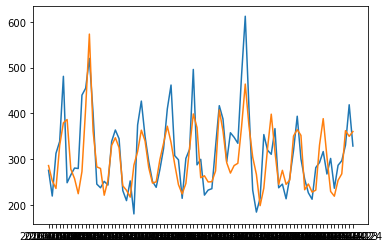

In [73]:
plt.plot(y_test)
plt.plot(y_test_pred)

In [74]:
filepath="cnn-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train,
                    batch_size=110, epochs=300,callbacks=[checkpoint])

Epoch 1/300
17/17 [==============================] - ETA: 0s - loss: 2284.9551
Epoch 1: loss improved from inf to 2284.95508, saving model to cnn-01-2284.96.hdf5
17/17 [==============================] - 3s 78ms/step - loss: 2284.9551
Epoch 2/300
17/17 [==============================] - ETA: 0s - loss: 1971.4590
Epoch 2: loss improved from 2284.95508 to 1971.45898, saving model to cnn-02-1971.46.hdf5
17/17 [==============================] - 1s 83ms/step - loss: 1971.4590
Epoch 3/300
17/17 [==============================] - ETA: 0s - loss: 1930.7617
Epoch 3: loss improved from 1971.45898 to 1930.76172, saving model to cnn-03-1930.76.hdf5
17/17 [==============================] - 1s 80ms/step - loss: 1930.7617
Epoch 4/300
17/17 [==============================] - ETA: 0s - loss: 1905.2686
Epoch 4: loss improved from 1930.76172 to 1905.26855, saving model to cnn-04-1905.27.hdf5
17/17 [==============================] - 1s 80ms/step - loss: 1905.2686
Epoch 5/300
17/17 [========================

In [87]:
model.load_weights("cnn-111-1310.86.hdf5")
model.compile(optimizer='adam', loss='mse')
X_test = np.array(X_test)
y_test_pred= model.predict(X_test)
y_test_pred = [i[1] for i in y_test_pred]

3/3 [==============================] - 0s 8ms/step


In [88]:
mape(y_test,y_test_pred)

0.14418433469773087

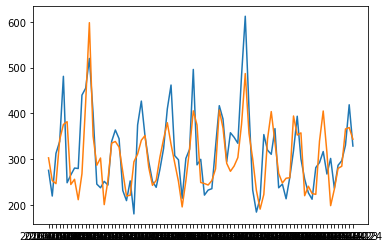

In [89]:
plt.plot(y_test)
plt.plot(y_test_pred)

In [47]:
foods_1_fm

FOODS_1  snap_CA  weekday_Monday  weekday_Saturday  \
date                                                             
2011-01-29      297        0               0                 1   
2011-01-30      284        0               0                 0   
2011-01-31      214        0               1                 0   
2011-02-01      175        1               0                 0   
2011-02-02      182        1               0                 0   
...             ...      ...             ...               ...   
2016-04-20      287        0               0                 0   
2016-04-21      297        0               0                 0   
2016-04-22      331        0               0                 0   
2016-04-23      419        0               0                 1   
2016-04-24      329        0               0                 0   

            weekday_Sunday  weekday_Thursday  weekday_Tuesday  \
date                                                            
2011-01-29               0                 0                0   
2011-01-30               1                 0                0   
2011-01-31               0                 0                0   
2011-02-01               0                 0                1   
2011-02-02               0                 0                0   
...                    ...               ...              ...   
2016-04-20               0                 0                0   
2016-04-21               0                 1                0   
2016-04-22               0                 0                0   
2016-04-23               0                 0                0   
2016-04-24               1                 0                0   

            weekday_Wednesday  event_1_ChristmasNational  \
date                                                       
2011-01-29                  0                          0   
2011-01-30                  0                          0   
2011-01-31                  0                          0   
2011-02-01                  0                          0   
2011-02-02                  1                          0   
...                       ...                        ...   
2016-04-20                  1                          0   
2016-04-21                  0                          0   
2016-04-22                  0                          0   
2016-04-23                  0                          0   
2016-04-24                  0                          0   

            event_1_Cinco De MayoCultural  ...  event_1_StPatricksDayCultural  \
date                                       ...                                  
2011-01-29                              0  ...                              0   
2011-01-30                              0  ...                              0   
2011-01-31                              0  ...                              0   
2011-02-01                              0  ...                              0   
2011-02-02                              0  ...                              0   
...                                   ...  ...                            ...   
2016-04-20                              0  ...                              0   
2016-04-21                              0  ...                              0   
2016-04-22                              0  ...                              0   
2016-04-23                              0  ...                              0   
2016-04-24                              0  ...                              0   

            event_1_SuperBowlSporting  event_1_ThanksgivingNational  \
date                                                                  
2011-01-29                          0                             0   
2011-01-30                          0                             0   
2011-01-31                          0                             0   
2011-02-01                          0                             0   
2011-02-02                          0         

# Multivariate LSTM - including not only information of lags, but also other information of the particular day

In [54]:
trainX=[]
trainY=[]
n_future=1
n_past = 30
for i in range(n_past,len(foods_1_fm)-n_future+1):
    trainX.append(foods_1_fm.iloc[i-n_past:i,0:foods_1_fm.shape[1]])
    trainY.append(foods_1_fm.iloc[i+n_future-1:i+n_future,0])

trainX = np.array(trainX)
trainY = np.array(trainY)

testX = [i for i in trainX[1800:]]
testY = [i for i in trainY[1800:]]

testX = np.array(testX)
testY = np.array(testY)

trainX = trainX[:1800]
trainY = trainY[:1800]

In [60]:
len(trainX)

1800

In [77]:
trainX.shape[2]

42

In [79]:
input_shape=(trainX.shape[1],trainX.shape[2])
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu',input_shape=input_shape,
               return_sequences=True))
model.add(LSTM(32, activation='relu',return_sequences=False))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam',loss='mse')

In [82]:
filepath="cnn-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=200,batch_size=20,verbose=1,validation_split=0.1,callbacks=[checkpoint])

Epoch 1/200
79/81 [============================>.] - ETA: 0s - loss: 5400.7422
Epoch 1: val_loss improved from inf to 6409.01465, saving model to cnn-01-6409.01.hdf5
81/81 [==============================] - 2s 24ms/step - loss: 5353.2168 - val_loss: 6409.0146
Epoch 2/200
79/81 [============================>.] - ETA: 0s - loss: 5280.1689
Epoch 2: val_loss did not improve from 6409.01465
81/81 [==============================] - 2s 24ms/step - loss: 5347.0322 - val_loss: 6409.8193
Epoch 3/200
79/81 [============================>.] - ETA: 0s - loss: 5173.1128
Epoch 3: val_loss improved from 6409.01465 to 5874.65283, saving model to cnn-03-5874.65.hdf5
81/81 [==============================] - 2s 24ms/step - loss: 5159.9619 - val_loss: 5874.6528
Epoch 4/200
79/81 [============================>.] - ETA: 0s - loss: 5306.4331
Epoch 4: val_loss did not improve from 5874.65283
81/81 [==============================] - 2s 23ms/step - loss: 5275.9307 - val_loss: 7130.7451
Epoch 5/200
79/81 [========

In [85]:
model.load_weights("cnn-149-3812.07.hdf5")
model.compile(optimizer='adam', loss='mse')
y_test_pred= model.predict(testX)

3/3 [==============================] - 0s 10ms/step


In [87]:
mape(testY, y_test_pred)

0.14188780281669885

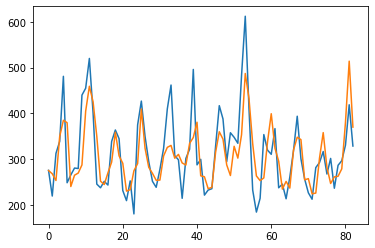

In [88]:
plt.plot(testY)
plt.plot(y_test_pred)

In [89]:
input_shape=(trainX.shape[1],trainX.shape[2])
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu',input_shape=input_shape,
               return_sequences=True))
model.add(LSTM(32, activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam',loss='mse')
filepath="cnn-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=300,batch_size=30,verbose=1,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/300
46/48 [===========================>..] - ETA: 0s - loss: 66903.0156
Epoch 1: val_loss improved from inf to 21793.11133, saving model to cnn-01-21793.11.hdf5
48/48 [==============================] - 4s 43ms/step - loss: 65406.0938 - val_loss: 21793.1113
Epoch 2/300
46/48 [===========================>..] - ETA: 0s - loss: 22515.6523
Epoch 2: val_loss improved from 21793.11133 to 14456.23730, saving model to cnn-02-14456.24.hdf5
48/48 [==============================] - 1s 26ms/step - loss: 22437.7480 - val_loss: 14456.2373
Epoch 3/300
46/48 [===========================>..] - ETA: 0s - loss: 16697.1055
Epoch 3: val_loss improved from 14456.23730 to 14178.50684, saving model to cnn-03-14178.51.hdf5
48/48 [==============================] - 1s 25ms/step - loss: 16426.2559 - val_loss: 14178.5068
Epoch 4/300
46/48 [===========================>..] - ETA: 0s - loss: 24512.9395
Epoch 4: val_loss did not improve from 14178.50684
48/48 [==============================] - 1s 25ms/step - lo

In [94]:
model.load_weights("cnn-252-4237.62.hdf5")
model.compile(optimizer='adam', loss='mse')
y_test_pred= model.predict(testX)
mape(testY, y_test_pred)

3/3 [==============================] - 0s 11ms/step


0.13471209087165434

# Best MAPE so far - only 13.47%

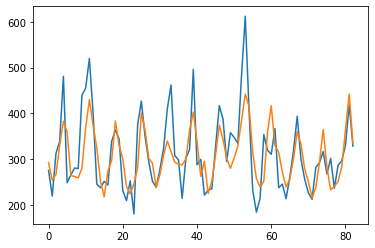

In [95]:
plt.plot(testY)
plt.plot(y_test_pred)

In [109]:
input_shape=(trainX.shape[1],trainX.shape[2])
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu',input_shape=input_shape,
               return_sequences=True))
#model.add(LSTM(64, activation=mish,return_sequences=False))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam',loss='mse')
filepath="cnn-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=1000,batch_size=30,verbose=1,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/1000
45/48 [===========================>..] - ETA: 0s - loss: 83002.1250
Epoch 1: val_loss improved from inf to 75848.35156, saving model to cnn-01-75848.35.hdf5
48/48 [==============================] - 3s 25ms/step - loss: 81334.9609 - val_loss: 75848.3516
Epoch 2/1000
48/48 [==============================] - ETA: 0s - loss: 56200.8164
Epoch 2: val_loss improved from 75848.35156 to 74109.58594, saving model to cnn-02-74109.59.hdf5
48/48 [==============================] - 1s 19ms/step - loss: 56200.8164 - val_loss: 74109.5859
Epoch 3/1000
45/48 [===========================>..] - ETA: 0s - loss: 50703.8633
Epoch 3: val_loss improved from 74109.58594 to 61170.39062, saving model to cnn-03-61170.39.hdf5
48/48 [==============================] - 1s 18ms/step - loss: 50312.3984 - val_loss: 61170.3906
Epoch 4/1000
45/48 [===========================>..] - ETA: 0s - loss: 40030.1914
Epoch 4: val_loss did not improve from 61170.39062
48/48 [==============================] - 1s 16ms/step 

In [114]:
np.mean(y_test_pred[0])

248.0479

In [115]:
model.load_weights("cnn-879-5393.82.hdf5")
model.compile(optimizer='adam', loss='mse')
y_test_pred= model.predict(testX)
y_test_pred = [np.mean(i) for i in y_test_pred]
mape(testY, y_test_pred)

3/3 [==============================] - 0s 8ms/step


0.15592684358034645

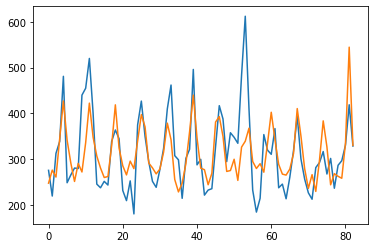

In [116]:
plt.plot(testY)
plt.plot(y_test_pred)

# Combining DNN with LSTM - trying to see if this can captue the residual patterns. We first build a DNN with information about the particular day as our x, and units sold as y. We then build a vanilla lstm with 30 lags. We combine both the ys DNN(y) and LSTM(y) as the inputs into another DNN, hoping it will be able to capture variations in the residual better

In [27]:
foods_1_fm

FOODS_1  snap_CA  weekday_Monday  weekday_Saturday  \
date                                                             
2011-01-29      297        0               0                 1   
2011-01-30      284        0               0                 0   
2011-01-31      214        0               1                 0   
2011-02-01      175        1               0                 0   
2011-02-02      182        1               0                 0   
...             ...      ...             ...               ...   
2016-04-20      287        0               0                 0   
2016-04-21      297        0               0                 0   
2016-04-22      331        0               0                 0   
2016-04-23      419        0               0                 1   
2016-04-24      329        0               0                 0   

            weekday_Sunday  weekday_Thursday  weekday_Tuesday  \
date                                                            
2011-01-29               0                 0                0   
2011-01-30               1                 0                0   
2011-01-31               0                 0                0   
2011-02-01               0                 0                1   
2011-02-02               0                 0                0   
...                    ...               ...              ...   
2016-04-20               0                 0                0   
2016-04-21               0                 1                0   
2016-04-22               0                 0                0   
2016-04-23               0                 0                0   
2016-04-24               1                 0                0   

            weekday_Wednesday  event_1_ChristmasNational  \
date                                                       
2011-01-29                  0                          0   
2011-01-30                  0                          0   
2011-01-31                  0                          0   
2011-02-01                  0                          0   
2011-02-02                  1                          0   
...                       ...                        ...   
2016-04-20                  1                          0   
2016-04-21                  0                          0   
2016-04-22                  0                          0   
2016-04-23                  0                          0   
2016-04-24                  0                          0   

            event_1_Cinco De MayoCultural  ...  event_1_StPatricksDayCultural  \
date                                       ...                                  
2011-01-29                              0  ...                              0   
2011-01-30                              0  ...                              0   
2011-01-31                              0  ...                              0   
2011-02-01                              0  ...                              0   
2011-02-02                              0  ...                              0   
...                                   ...  ...                            ...   
2016-04-20                              0  ...                              0   
2016-04-21                              0  ...                              0   
2016-04-22                              0  ...                              0   
2016-04-23                              0  ...                              0   
2016-04-24                              0  ...                              0   

            event_1_SuperBowlSporting  event_1_ThanksgivingNational  \
date                                                                  
2011-01-29                          0                             0   
2011-01-30                          0                             0   
2011-01-31                          0                             0   
2011-02-01                          0                             0   
2011-02-02                          0         

In [28]:
X_train = foods_1_fm.iloc[30:1830,1:]
y_train = foods_1_fm.iloc[30:1830,0]
X_test = foods_1_fm.iloc[1830:,1:]
y_test = foods_1_fm.iloc[1830:,0]

In [29]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [30]:
y_train.shape

(1800,)

In [31]:
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

def build_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(41, )))
    model.add(Dense(32, activation=mish))
    model.add(Dense(64, activation=mish))
    model.add(Dense(128, activation=mish))
    model.add(Dense(256, activation=mish))
    model.add(Dense(512, activation=mish))
    model.add(Dense(1024, activation=mish))
    model.add(Dense(2048, activation=mish))
    model.add(Dense(1, activation='linear'))
    return model

In [34]:
model = build_model()
model.compile(optimizer='adam',
                  loss='mse')

In [35]:
filepath="cnn-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train,
                    batch_size=20, epochs=300,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/300
72/72 [==============================] - ETA: 0s - loss: 20549.8652
Epoch 1: val_loss improved from inf to 9452.53516, saving model to cnn-01-9452.54.hdf5
72/72 [==============================] - 7s 62ms/step - loss: 20549.8652 - val_loss: 9452.5352
Epoch 2/300
72/72 [==============================] - ETA: 0s - loss: 7399.5938
Epoch 2: val_loss improved from 9452.53516 to 8636.39551, saving model to cnn-02-8636.40.hdf5
72/72 [==============================] - 4s 56ms/step - loss: 7399.5938 - val_loss: 8636.3955
Epoch 3/300
71/72 [============================>.] - ETA: 0s - loss: 6933.0796
Epoch 3: val_loss did not improve from 8636.39551
72/72 [==============================] - 4s 51ms/step - loss: 6885.8237 - val_loss: 9259.9570
Epoch 4/300
71/72 [============================>.] - ETA: 0s - loss: 6874.3228
Epoch 4: val_loss did not improve from 8636.39551
72/72 [==============================] - 4s 51ms/step - loss: 6844.6924 - val_loss: 11402.3408
Epoch 5/300
71/72 [=====

In [37]:
model.load_weights("cnn-06-6863.79.hdf5")
model.compile(optimizer='adam', loss='mse')
X_test = np.array(X_test)
y_test_pred= model.predict(X_test)
y_test_pred = [i[0] for i in y_test_pred]

3/3 [==============================] - 0s 9ms/step


In [38]:
mape(y_test, y_test_pred)

0.15753383213906916

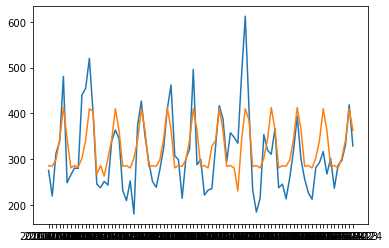

In [39]:
plt.plot(y_test)
plt.plot(y_test_pred)

In [40]:
model.predict(X_train)

57/57 [==============================] - 1s 8ms/step


array([[284.53503],
       [286.2625 ],
       [284.91867],
       ...,
       [410.18704],
       [362.9392 ],
       [281.46906]], dtype=float32)

In [41]:
X_train_for_next = [i[0] for i in model.predict(X_train)]

57/57 [==============================] - 0s 8ms/step


In [42]:
X_test_for_next = [i[0] for i in model.predict(X_test)]

3/3 [==============================] - 0s 6ms/step


In [43]:
foods_1_fm

FOODS_1  snap_CA  weekday_Monday  weekday_Saturday  \
date                                                             
2011-01-29      297        0               0                 1   
2011-01-30      284        0               0                 0   
2011-01-31      214        0               1                 0   
2011-02-01      175        1               0                 0   
2011-02-02      182        1               0                 0   
...             ...      ...             ...               ...   
2016-04-20      287        0               0                 0   
2016-04-21      297        0               0                 0   
2016-04-22      331        0               0                 0   
2016-04-23      419        0               0                 1   
2016-04-24      329        0               0                 0   

            weekday_Sunday  weekday_Thursday  weekday_Tuesday  \
date                                                            
2011-01-29               0                 0                0   
2011-01-30               1                 0                0   
2011-01-31               0                 0                0   
2011-02-01               0                 0                1   
2011-02-02               0                 0                0   
...                    ...               ...              ...   
2016-04-20               0                 0                0   
2016-04-21               0                 1                0   
2016-04-22               0                 0                0   
2016-04-23               0                 0                0   
2016-04-24               1                 0                0   

            weekday_Wednesday  event_1_ChristmasNational  \
date                                                       
2011-01-29                  0                          0   
2011-01-30                  0                          0   
2011-01-31                  0                          0   
2011-02-01                  0                          0   
2011-02-02                  1                          0   
...                       ...                        ...   
2016-04-20                  1                          0   
2016-04-21                  0                          0   
2016-04-22                  0                          0   
2016-04-23                  0                          0   
2016-04-24                  0                          0   

            event_1_Cinco De MayoCultural  ...  event_1_StPatricksDayCultural  \
date                                       ...                                  
2011-01-29                              0  ...                              0   
2011-01-30                              0  ...                              0   
2011-01-31                              0  ...                              0   
2011-02-01                              0  ...                              0   
2011-02-02                              0  ...                              0   
...                                   ...  ...                            ...   
2016-04-20                              0  ...                              0   
2016-04-21                              0  ...                              0   
2016-04-22                              0  ...                              0   
2016-04-23                              0  ...                              0   
2016-04-24                              0  ...                              0   

            event_1_SuperBowlSporting  event_1_ThanksgivingNational  \
date                                                                  
2011-01-29                          0                             0   
2011-01-30                          0                             0   
2011-01-31                          0                             0   
2011-02-01                          0                             0   
2011-02-02                          0         

In [44]:
X_train, y_train = split_sequence(list(foods_1_fm[:1830]['FOODS_1']), 30)
X_test, y_test = split_sequence(list(foods_1_fm[1800:]['FOODS_1']), 30)

In [45]:
len(X_test)

83

In [46]:
foods_1_fm.iloc[1830:,0]

date
2016-02-02    276
2016-02-03    220
2016-02-04    313
2016-02-05    339
2016-02-06    481
             ... 
2016-04-20    287
2016-04-21    297
2016-04-22    331
2016-04-23    419
2016-04-24    329
Name: FOODS_1, Length: 83, dtype: int64

In [47]:
y_test

array([276, 220, 313, 339, 481, 249, 266, 281, 280, 440, 455, 520, 401,
       246, 238, 252, 244, 339, 364, 345, 232, 210, 253, 181, 375, 427,
       350, 295, 252, 239, 278, 324, 410, 462, 308, 299, 215, 302, 322,
       496, 288, 300, 222, 233, 236, 328, 417, 388, 295, 358, 348, 335,
       483, 612, 411, 233, 185, 215, 354, 320, 311, 367, 238, 246, 214,
       261, 319, 394, 301, 257, 227, 213, 282, 293, 317, 268, 302, 237,
       287, 297, 331, 419, 329])

In [48]:
model = tf.keras.Sequential()
model.add(LSTM(50, activation='relu', input_shape=(30, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

n_features = 1
filepath="lstm-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
model.fit(X_train, y_train, epochs=1000,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/1000
45/45 [==============================] - ETA: 0s - loss: 307064.8750
Epoch 1: val_loss improved from inf to 75676.23438, saving model to lstm-01-75676.23.hdf5
45/45 [==============================] - 2s 23ms/step - loss: 307064.8750 - val_loss: 75676.2344
Epoch 2/1000
45/45 [==============================] - ETA: 0s - loss: 21290.7773
Epoch 2: val_loss improved from 75676.23438 to 63181.10547, saving model to lstm-02-63181.11.hdf5
45/45 [==============================] - 1s 16ms/step - loss: 21290.7773 - val_loss: 63181.1055
Epoch 3/1000
45/45 [==============================] - ETA: 0s - loss: 22853.2949
Epoch 3: val_loss improved from 63181.10547 to 9342.54199, saving model to lstm-03-9342.54.hdf5
45/45 [==============================] - 1s 16ms/step - loss: 22853.2949 - val_loss: 9342.5420
Epoch 4/1000
45/45 [==============================] - ETA: 0s - loss: 6556.5000
Epoch 4: val_loss improved from 9342.54199 to 7917.31396, saving model to lstm-04-7917.31.hdf5
45/45 [==

In [49]:
model.load_weights("lstm-724-4520.52.hdf5")
model.compile(optimizer='adam', loss='mse')
X_test = np.array(X_test)
y_test_pred= model.predict(X_test)

3/3 [==============================] - 0s 8ms/step


In [50]:
mape(y_test,y_test_pred)

0.16017750777077439

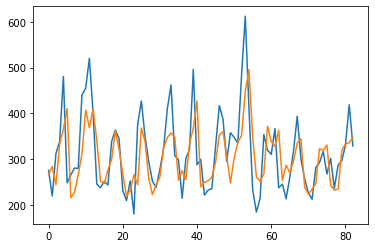

In [51]:
plt.plot(y_test)
plt.plot(y_test_pred)

In [52]:
X_train_for_next_2 = [i[0] for i in model.predict(X_train)]

57/57 [==============================] - 1s 6ms/step


In [53]:
X_train_for_next_2

[205.43147,
 157.90909,
 218.3862,
 203.85258,
 251.48198,
 263.03177,
 310.50873,
 234.70918,
 184.48682,
 211.61652,
 221.2296,
 222.45627,
 283.21497,
 306.18988,
 242.55132,
 204.71968,
 205.4773,
 222.9493,
 216.54628,
 292.6586,
 273.45053,
 217.29352,
 204.22516,
 200.25941,
 187.74136,
 200.81285,
 235.34178,
 257.04068,
 181.48355,
 139.61987,
 166.2098,
 181.01842,
 177.40025,
 208.56903,
 212.86113,
 204.24376,
 126.5224,
 161.1836,
 172.90378,
 197.71558,
 199.85873,
 213.25165,
 156.12723,
 129.11874,
 150.92897,
 157.82948,
 167.17636,
 193.40692,
 187.38011,
 181.57492,
 123.11836,
 140.20683,
 157.17294,
 208.83687,
 302.47015,
 340.11462,
 147.85287,
 130.8498,
 129.60446,
 139.86044,
 151.00911,
 192.98965,
 168.99976,
 152.87302,
 131.32005,
 172.58089,
 162.62422,
 206.63622,
 239.97472,
 238.5609,
 188.99792,
 169.2914,
 169.96571,
 164.58304,
 201.23389,
 208.5819,
 241.56367,
 162.3893,
 144.48813,
 163.53151,
 189.7994,
 169.73346,
 221.16844,
 187.63356,
 149.6

In [54]:
X_test_for_next_2 = [i[0] for i in model.predict(X_test)]

3/3 [==============================] - 0s 5ms/step


In [55]:
df_comb = pd.DataFrame()
df_comb['cnn_out'] = X_train_for_next
df_comb['lstm_out'] = X_train_for_next_2

In [56]:
df_comb['req_out'] = y_train

# This is the dataset we will feed into our DNN

In [57]:
df_comb

cnn_out    lstm_out  req_out
0     284.535034  205.431473      177
1     286.262512  157.909088      276
2     284.918671  218.386200      203
3     299.263947  203.852585      216
4     343.490967  251.481979      230
...          ...         ...      ...
1795  302.455658  226.247086      255
1796  341.819824  272.841858      357
1797  410.187042  367.288422      380
1798  362.939209  318.300598      366
1799  281.469055  290.903595      314

[1800 rows x 3 columns]

In [58]:
df_comb_test = pd.DataFrame()
df_comb_test['cnn_out'] = X_test_for_next
df_comb_test['lstm_out'] = X_test_for_next_2
df_comb_test['req_out'] = y_test

In [59]:
df_comb_test

cnn_out    lstm_out  req_out
0   286.262512  267.072479      276
1   284.918671  284.441803      220
2   299.263947  244.625443      313
3   343.490967  334.005798      339
4   412.886932  365.390533      481
..         ...         ...      ...
78  281.173889  235.202118      287
79  302.455658  319.150055      297
80  341.819824  333.452026      331
81  410.187042  336.356567      419
82  362.939209  347.484924      329

[83 rows x 3 columns]

In [60]:
X_train = np.array(df_comb.iloc[:,:2])
y_train = np.array(df_comb.iloc[:,2])
X_test= np.array(df_comb_test.iloc[:,:2])
y_test = np.array(df_comb_test.iloc[:,2])

In [61]:
X_train.shape

(1800, 2)

In [16]:
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

def build_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(2, )))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model

In [68]:
model = build_model()
model.compile(optimizer='adam',
                  loss='mse')
filepath="cnn-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train,
                    batch_size=10, epochs=700,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/700
128/144 [=========================>....] - ETA: 0s - loss: 6147.3599
Epoch 1: val_loss improved from inf to 4050.14502, saving model to cnn-01-4050.15.hdf5
144/144 [==============================] - 2s 6ms/step - loss: 5723.0127 - val_loss: 4050.1450
Epoch 2/700
126/144 [=========================>....] - ETA: 0s - loss: 3177.5312
Epoch 2: val_loss did not improve from 4050.14502
144/144 [==============================] - 0s 3ms/step - loss: 3117.0906 - val_loss: 4502.2900
Epoch 3/700
129/144 [=========================>....] - ETA: 0s - loss: 3054.0046
Epoch 3: val_loss did not improve from 4050.14502
144/144 [==============================] - 0s 3ms/step - loss: 3126.1521 - val_loss: 5022.4058
Epoch 4/700
129/144 [=========================>....] - ETA: 0s - loss: 3130.0374
Epoch 4: val_loss did not improve from 4050.14502
144/144 [==============================] - 0s 3ms/step - loss: 3096.9089 - val_loss: 4512.1113
Epoch 5/700
144/144 [==============================] - ETA:

In [69]:
model.load_weights("cnn-187-3719.27.hdf5")
model.compile(optimizer='adam', loss='mse')
X_test = np.array(X_test)
y_test_pred= model.predict(X_test)
y_test_pred = [i[0] for i in y_test_pred]
mape(y_test,y_test_pred)

3/3 [==============================] - 0s 2ms/step


0.1500759919317059

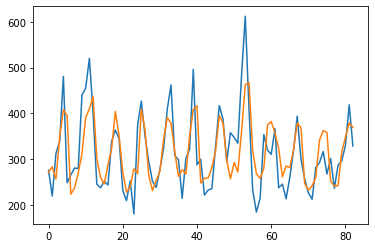

In [70]:
plt.plot(y_test)
plt.plot(y_test_pred)

# Though the MAPE did not improve, we can see that the variations in residuals have been captured

# Multivariate LSTM performs the best. Using it for foods_2 and food_3 in CA_1 and all other stores in CA

# foods_2

In [17]:
df_ca_foods_2 = df_sales[(df_sales['cat_id']=='FOODS')
                         &(df_sales['dept_id']=='FOODS_2')
                         &(df_sales['store_id']=='CA_1')]
foods_2 = df_ca_foods_2.groupby('dept_id').sum().T.reset_index()

foods_2.rename({'index':'d'},axis=1,inplace=True)

df_calender.fillna('nothing',axis=1,inplace=True)

foods_2_fm = foods_2.merge(df_calender, on='d').drop(['snap_TX','snap_WI','wday','d'],axis=1)

In [18]:
foods_2_fm['event_1'] = foods_2_fm['event_name_1']+foods_2_fm['event_type_1']
foods_2_fm['event_2'] = foods_2_fm['event_name_2']+foods_2_fm['event_type_2']

foods_2_fm.drop(['event_name_1','event_type_1','event_name_2','event_type_2','wm_yr_wk'],axis=1,inplace=True)

foods_2_fm = pd.concat([foods_2_fm,pd.get_dummies(foods_2_fm[['weekday','month','event_1','event_2']],drop_first=True)],axis=1)

foods_2_fm.drop(['weekday','month','event_1','event_2','year'],axis=1,inplace=True)

foods_2_fm.set_index('date',inplace=True)

In [19]:
trainX=[]
trainY=[]
n_future=1
n_past = 30
for i in range(n_past,len(foods_2_fm)-n_future+1):
    trainX.append(foods_2_fm.iloc[i-n_past:i,0:foods_2_fm.shape[1]])
    trainY.append(foods_2_fm.iloc[i+n_future-1:i+n_future,0])

trainX = np.array(trainX)
trainY = np.array(trainY)

testX = [i for i in trainX[1800:]]
testY = [i for i in trainY[1800:]]

testX = np.array(testX)
testY = np.array(testY)

trainX = trainX[:1800]
trainY = trainY[:1800]

In [24]:
input_shape=(trainX.shape[1],trainX.shape[2])
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu',input_shape=input_shape,
               return_sequences=True))
model.add(LSTM(32, activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam',loss='mse')
filepath="multi_LSTM.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=1000,batch_size=20,verbose=1,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/1000
70/72 [============================>.] - ETA: 0s - loss: 153828.7031
Epoch 1: val_loss improved from inf to 88279.25781, saving model to multi_LSTM.hdf5
72/72 [==============================] - 5s 33ms/step - loss: 151579.0625 - val_loss: 88279.2578
Epoch 2/1000
72/72 [==============================] - ETA: 0s - loss: 211042.4844
Epoch 2: val_loss did not improve from 88279.25781
72/72 [==============================] - 2s 25ms/step - loss: 211042.4844 - val_loss: 243869.0938
Epoch 3/1000
70/72 [============================>.] - ETA: 0s - loss: 195666.4531
Epoch 3: val_loss did not improve from 88279.25781
72/72 [==============================] - 2s 25ms/step - loss: 193953.5781 - val_loss: 149920.1406
Epoch 4/1000
70/72 [============================>.] - ETA: 0s - loss: 161360.3438
Epoch 4: val_loss did not improve from 88279.25781
72/72 [==============================] - 2s 26ms/step - loss: 161113.4375 - val_loss: 204775.4062
Epoch 5/1000
70/72 [========================

In [25]:
model.load_weights("multi_LSTM.hdf5")
model.compile(optimizer='adam', loss='mse')
y_test_pred= model.predict(testX)
mape(testY, y_test_pred)

3/3 [==============================] - 0s 12ms/step


0.10133939186106954

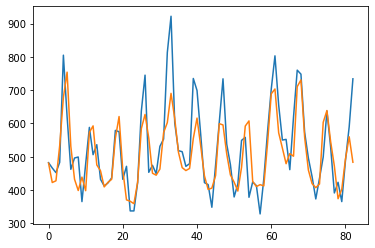

In [26]:
plt.plot(testY)
plt.plot(y_test_pred)

# foods_3

In [6]:
df_ca_foods_3 = df_sales[(df_sales['cat_id']=='FOODS')
                         &(df_sales['dept_id']=='FOODS_3')
                         &(df_sales['store_id']=='CA_1')]
foods_3 = df_ca_foods_3.groupby('dept_id').sum().T.reset_index()

foods_3.rename({'index':'d'},axis=1,inplace=True)

df_calender.fillna('nothing',axis=1,inplace=True)

foods_3_fm = foods_3.merge(df_calender, on='d').drop(['snap_TX','snap_WI','wday','d'],axis=1)

foods_3_fm['event_1'] = foods_3_fm['event_name_1']+foods_3_fm['event_type_1']
foods_3_fm['event_2'] = foods_3_fm['event_name_2']+foods_3_fm['event_type_2']

foods_3_fm.drop(['event_name_1','event_type_1','event_name_2','event_type_2','wm_yr_wk'],axis=1,inplace=True)

foods_3_fm = pd.concat([foods_3_fm,pd.get_dummies(foods_3_fm[['weekday','month','event_1','event_2']],drop_first=True)],axis=1)

foods_3_fm.drop(['weekday','month','event_1','event_2','year'],axis=1,inplace=True)

foods_3_fm.set_index('date',inplace=True)

trainX=[]
trainY=[]
n_future=1
n_past = 30
for i in range(n_past,len(foods_3_fm)-n_future+1):
    trainX.append(foods_3_fm.iloc[i-n_past:i,0:foods_3_fm.shape[1]])
    trainY.append(foods_3_fm.iloc[i+n_future-1:i+n_future,0])

trainX = np.array(trainX)
trainY = np.array(trainY)

testX = [i for i in trainX[1800:]]
testY = [i for i in trainY[1800:]]

testX = np.array(testX)
testY = np.array(testY)

trainX = trainX[:1800]
trainY = trainY[:1800]

In [13]:
input_shape=(trainX.shape[1],trainX.shape[2])
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu',input_shape=input_shape,
               return_sequences=True))
model.add(LSTM(32, activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam',loss='mse')
filepath="multi_LSTM_foods_3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=1000,batch_size=20,verbose=1,validation_split=0.2,callbacks=[checkpoint])

2023-02-13 14:12:14.420212: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib/python3.8/site-packages:/apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib/python3.8:/apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib:/usr/lib64
2023-02-13 14:12:14.420284: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-13 14:12:14.420914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow b

Epoch 1/1000
70/72 [============================>.] - ETA: 0s - loss: 1999587.5000
Epoch 1: val_loss improved from inf to 948951.00000, saving model to multi_LSTM_foods_3.hdf5
72/72 [==============================] - 5s 29ms/step - loss: 1991695.5000 - val_loss: 948951.0000
Epoch 2/1000
70/72 [============================>.] - ETA: 0s - loss: 1317856.7500
Epoch 2: val_loss did not improve from 948951.00000
72/72 [==============================] - 2s 21ms/step - loss: 1324413.6250 - val_loss: 989531.6250
Epoch 3/1000
70/72 [============================>.] - ETA: 0s - loss: 1151563.3750
Epoch 3: val_loss improved from 948951.00000 to 724208.06250, saving model to multi_LSTM_foods_3.hdf5
72/72 [==============================] - 2s 21ms/step - loss: 1148487.8750 - val_loss: 724208.0625
Epoch 4/1000
70/72 [============================>.] - ETA: 0s - loss: 1231953.3750
Epoch 4: val_loss did not improve from 724208.06250
72/72 [==============================] - 2s 21ms/step - loss: 1232884.50

In [14]:
model.load_weights("multi_LSTM_foods_3.hdf5")
model.compile(optimizer='adam', loss='mse')
y_test_pred= model.predict(testX)
mape(testY, y_test_pred)

3/3 [==============================] - 0s 9ms/step


0.0629805672530853

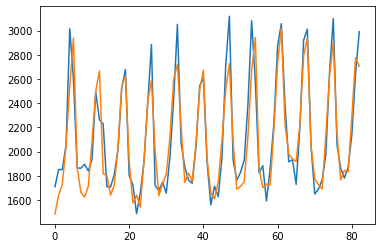

In [15]:
plt.plot(testY)
plt.plot(y_test_pred)

In [17]:
df_ca_s2_foods_1 = df_sales[(df_sales['cat_id']=='FOODS')
                         &(df_sales['dept_id']=='FOODS_1')
                         &(df_sales['store_id']=='CA_2')]
s2_foods_1 = df_ca_s2_foods_1.groupby('dept_id').sum().T.reset_index()

s2_foods_1.rename({'index':'d'},axis=1,inplace=True)

df_calender.fillna('nothing',axis=1,inplace=True)

s2_foods_1_fm = s2_foods_1.merge(df_calender, on='d').drop(['snap_TX','snap_WI','wday','d'],axis=1)

s2_foods_1_fm['event_1'] = s2_foods_1_fm['event_name_1']+s2_foods_1_fm['event_type_1']
s2_foods_1_fm['event_2'] = s2_foods_1_fm['event_name_2']+s2_foods_1_fm['event_type_2']

s2_foods_1_fm.drop(['event_name_1','event_type_1','event_name_2','event_type_2','wm_yr_wk'],axis=1,inplace=True)

s2_foods_1_fm = pd.concat([s2_foods_1_fm,pd.get_dummies(s2_foods_1_fm[['weekday','month','event_1','event_2']],drop_first=True)],axis=1)

s2_foods_1_fm.drop(['weekday','month','event_1','event_2','year'],axis=1,inplace=True)

s2_foods_1_fm.set_index('date',inplace=True)

trainX=[]
trainY=[]
n_future=1
n_past = 30
for i in range(n_past,len(s2_foods_1_fm)-n_future+1):
    trainX.append(s2_foods_1_fm.iloc[i-n_past:i,0:s2_foods_1_fm.shape[1]])
    trainY.append(s2_foods_1_fm.iloc[i+n_future-1:i+n_future,0])

trainX = np.array(trainX)
trainY = np.array(trainY)

testX = [i for i in trainX[1800:]]
testY = [i for i in trainY[1800:]]

testX = np.array(testX)
testY = np.array(testY)

trainX = trainX[:1800]
trainY = trainY[:1800]

In [18]:
input_shape=(trainX.shape[1],trainX.shape[2])
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu',input_shape=input_shape,
               return_sequences=True))
model.add(LSTM(32, activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam',loss='mse')
filepath="multi_LSTM_ca2_foods_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=1000,batch_size=20,verbose=1,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/1000
70/72 [============================>.] - ETA: 0s - loss: 124195.3750
Epoch 1: val_loss improved from inf to 92120.85156, saving model to multi_LSTM_ca2_foods_1.hdf5
72/72 [==============================] - 4s 28ms/step - loss: 122909.4297 - val_loss: 92120.8516
Epoch 2/1000
70/72 [============================>.] - ETA: 0s - loss: 80881.5859
Epoch 2: val_loss improved from 92120.85156 to 72912.57031, saving model to multi_LSTM_ca2_foods_1.hdf5
72/72 [==============================] - 2s 21ms/step - loss: 80692.2031 - val_loss: 72912.5703
Epoch 3/1000
70/72 [============================>.] - ETA: 0s - loss: 75603.1016
Epoch 3: val_loss did not improve from 72912.57031
72/72 [==============================] - 1s 21ms/step - loss: 75400.0469 - val_loss: 77802.4297
Epoch 4/1000
70/72 [============================>.] - ETA: 0s - loss: 83766.6484
Epoch 4: val_loss did not improve from 72912.57031
72/72 [==============================] - 2s 21ms/step - loss: 83720.4922 - val_loss:

In [19]:
model.load_weights("multi_LSTM_ca2_foods_1.hdf5")
model.compile(optimizer='adam', loss='mse')
y_test_pred= model.predict(testX)
mape(testY, y_test_pred)

3/3 [==============================] - 0s 10ms/step


0.15776829671247097

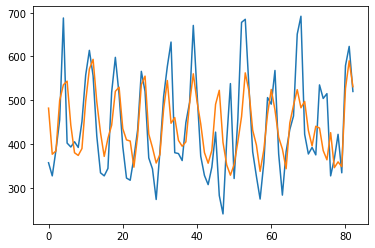

In [20]:
plt.plot(testY)
plt.plot(y_test_pred)

In [6]:
df_ca_s2_foods_2 = df_sales[(df_sales['cat_id']=='FOODS')
                         &(df_sales['dept_id']=='FOODS_2')
                         &(df_sales['store_id']=='CA_2')]
s2_foods_2 = df_ca_s2_foods_2.groupby('dept_id').sum().T.reset_index()

s2_foods_2.rename({'index':'d'},axis=1,inplace=True)

df_calender.fillna('nothing',axis=1,inplace=True)

s2_foods_2_fm = s2_foods_2.merge(df_calender, on='d').drop(['snap_TX','snap_WI','wday','d'],axis=1)

s2_foods_2_fm['event_1'] = s2_foods_2_fm['event_name_1']+s2_foods_2_fm['event_type_1']
s2_foods_2_fm['event_2'] = s2_foods_2_fm['event_name_2']+s2_foods_2_fm['event_type_2']

s2_foods_2_fm.drop(['event_name_1','event_type_1','event_name_2','event_type_2','wm_yr_wk'],axis=1,inplace=True)

s2_foods_2_fm = pd.concat([s2_foods_2_fm,pd.get_dummies(s2_foods_2_fm[['weekday','month','event_1','event_2']],drop_first=True)],axis=1)

s2_foods_2_fm.drop(['weekday','month','event_1','event_2','year'],axis=1,inplace=True)

s2_foods_2_fm.set_index('date',inplace=True)

trainX=[]
trainY=[]
n_future=1
n_past = 30
for i in range(n_past,len(s2_foods_2_fm)-n_future+1):
    trainX.append(s2_foods_2_fm.iloc[i-n_past:i,0:s2_foods_2_fm.shape[1]])
    trainY.append(s2_foods_2_fm.iloc[i+n_future-1:i+n_future,0])

trainX = np.array(trainX)
trainY = np.array(trainY)

testX = [i for i in trainX[1800:]]
testY = [i for i in trainY[1800:]]

testX = np.array(testX)
testY = np.array(testY)

trainX = trainX[:1800]
trainY = trainY[:1800]

In [7]:
input_shape=(trainX.shape[1],trainX.shape[2])
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu',input_shape=input_shape,
               return_sequences=True))
model.add(LSTM(32, activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam',loss='mse')
filepath="multi_LSTM_ca2_foods_2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=1000,batch_size=20,verbose=1,validation_split=0.2,callbacks=[checkpoint])

2023-02-15 14:06:08.325092: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib/python3.8/site-packages:/apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib/python3.8:/apps/spack/gilbreth/apps/anaconda/2020.11-py38-gcc-4.8.5-djkvkvk/lib:/usr/lib64
2023-02-15 14:06:08.328706: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-15 14:06:08.336677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow b

Epoch 1/1000
70/72 [============================>.] - ETA: 0s - loss: 16499.9609
Epoch 1: val_loss improved from inf to 90694.31250, saving model to multi_LSTM_ca2_foods_2.hdf5
72/72 [==============================] - 5s 35ms/step - loss: 16324.0635 - val_loss: 90694.3125
Epoch 2/1000
72/72 [==============================] - ETA: 0s - loss: 5984.4238
Epoch 2: val_loss improved from 90694.31250 to 30032.56641, saving model to multi_LSTM_ca2_foods_2.hdf5
72/72 [==============================] - 2s 27ms/step - loss: 5984.4238 - val_loss: 30032.5664
Epoch 3/1000
71/72 [============================>.] - ETA: 0s - loss: 6278.2744
Epoch 3: val_loss did not improve from 30032.56641
72/72 [==============================] - 2s 26ms/step - loss: 6293.7861 - val_loss: 57311.2500
Epoch 4/1000
70/72 [============================>.] - ETA: 0s - loss: 5976.0322
Epoch 4: val_loss improved from 30032.56641 to 22131.01172, saving model to multi_LSTM_ca2_foods_2.hdf5
72/72 [==============================]

In [8]:
model.load_weights("multi_LSTM_ca2_foods_2.hdf5")
model.compile(optimizer='adam', loss='mse')
y_test_pred= model.predict(testX)
mape(testY, y_test_pred)

3/3 [==============================] - 1s 12ms/step


1.1532121954564025

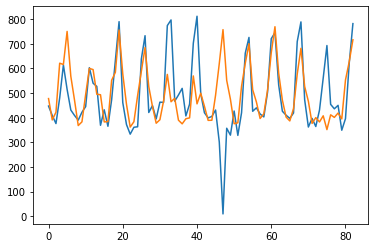

In [9]:
plt.plot(testY)
plt.plot(y_test_pred)

In [14]:
df_ca_s2_foods_3 = df_sales[(df_sales['cat_id']=='FOODS')
                         &(df_sales['dept_id']=='FOODS_3')
                         &(df_sales['store_id']=='CA_2')]
s2_foods_3 = df_ca_s2_foods_3.groupby('dept_id').sum().T.reset_index()

s2_foods_3.rename({'index':'d'},axis=1,inplace=True)

df_calender.fillna('nothing',axis=1,inplace=True)

s2_foods_3_fm = s2_foods_3.merge(df_calender, on='d').drop(['snap_TX','snap_WI','wday','d'],axis=1)

s2_foods_3_fm['event_1'] = s2_foods_3_fm['event_name_1']+s2_foods_3_fm['event_type_1']
s2_foods_3_fm['event_2'] = s2_foods_3_fm['event_name_2']+s2_foods_3_fm['event_type_2']

s2_foods_3_fm.drop(['event_name_1','event_type_1','event_name_2','event_type_2','wm_yr_wk'],axis=1,inplace=True)

s2_foods_3_fm = pd.concat([s2_foods_3_fm,pd.get_dummies(s2_foods_3_fm[['weekday','month','event_1','event_2']],drop_first=True)],axis=1)

s2_foods_3_fm.drop(['weekday','month','event_1','event_2','year'],axis=1,inplace=True)

s2_foods_3_fm.set_index('date',inplace=True)

trainX=[]
trainY=[]
n_future=1
n_past = 30
for i in range(n_past,len(s2_foods_3_fm)-n_future+1):
    trainX.append(s2_foods_3_fm.iloc[i-n_past:i,0:s2_foods_3_fm.shape[1]])
    trainY.append(s2_foods_3_fm.iloc[i+n_future-1:i+n_future,0])

trainX = np.array(trainX)
trainY = np.array(trainY)

testX = [i for i in trainX[1800:]]
testY = [i for i in trainY[1800:]]

testX = np.array(testX)
testY = np.array(testY)

trainX = trainX[:1800]
trainY = trainY[:1800]

In [7]:
input_shape=(trainX.shape[1],trainX.shape[2])
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu',input_shape=input_shape,
               return_sequences=True))
model.add(LSTM(32, activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam',loss='mse')
filepath="multi_LSTM_ca2_foods_3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',patience=50)
history = model.fit(trainX, trainY, epochs=500,batch_size=20,verbose=1,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/500
70/72 [============================>.] - ETA: 0s - loss: 1963898.1250
Epoch 1: val_loss improved from inf to 2130037.75000, saving model to multi_LSTM_ca2_foods_3.hdf5
72/72 [==============================] - 5s 32ms/step - loss: 1979744.8750 - val_loss: 2130037.7500
Epoch 2/500
70/72 [============================>.] - ETA: 0s - loss: 1557748.1250
Epoch 2: val_loss did not improve from 2130037.75000
72/72 [==============================] - 2s 21ms/step - loss: 1554245.7500 - val_loss: 2142673.0000
Epoch 3/500
70/72 [============================>.] - ETA: 0s - loss: 648978.1875
Epoch 3: val_loss improved from 2130037.75000 to 345718.87500, saving model to multi_LSTM_ca2_foods_3.hdf5
72/72 [==============================] - 2s 24ms/step - loss: 635722.6875 - val_loss: 345718.8750
Epoch 4/500
71/72 [============================>.] - ETA: 0s - loss: 275131.2500
Epoch 4: val_loss did not improve from 345718.87500
72/72 [==============================] - 2s 27ms/step - loss: 2762

In [15]:
model.load_weights("multi_LSTM_ca2_foods_3.hdf5")
model.compile(optimizer='adam', loss='mse')
y_test_pred= model.predict(testX)
mape(testY, y_test_pred)

3/3 [==============================] - 0s 9ms/step


0.14953061783125543

57/57 [==============================] - 1s 9ms/step


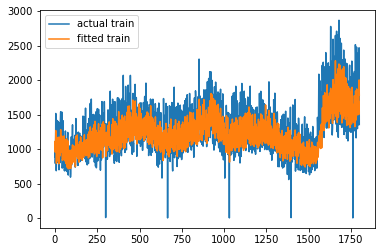

In [18]:
plt.plot(trainY, label='actual train')
plt.plot(model.predict(trainX), label='fitted train')
plt.legend()

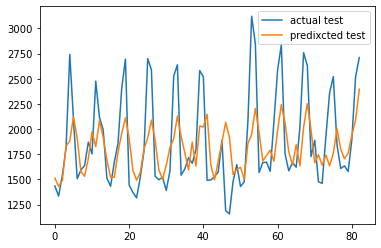

In [19]:
plt.plot(testY, label = 'actual test')
plt.plot(y_test_pred, label='predixcted test')
plt.legend()

In [20]:
df_ca_s3_foods_1 = df_sales[(df_sales['cat_id']=='FOODS')
                         &(df_sales['dept_id']=='FOODS_1')
                         &(df_sales['store_id']=='CA_3')]
s3_foods_1 = df_ca_s3_foods_1.groupby('dept_id').sum().T.reset_index()

s3_foods_1.rename({'index':'d'},axis=1,inplace=True)

df_calender.fillna('nothing',axis=1,inplace=True)

s3_foods_1_fm = s3_foods_1.merge(df_calender, on='d').drop(['snap_TX','snap_WI','wday','d'],axis=1)

s3_foods_1_fm['event_1'] = s3_foods_1_fm['event_name_1']+s3_foods_1_fm['event_type_1']
s3_foods_1_fm['event_2'] = s3_foods_1_fm['event_name_2']+s3_foods_1_fm['event_type_2']

s3_foods_1_fm.drop(['event_name_1','event_type_1','event_name_2','event_type_2','wm_yr_wk'],axis=1,inplace=True)

s3_foods_1_fm = pd.concat([s3_foods_1_fm,pd.get_dummies(s3_foods_1_fm[['weekday','month','event_1','event_2']],drop_first=True)],axis=1)

s3_foods_1_fm.drop(['weekday','month','event_1','event_2','year'],axis=1,inplace=True)

s3_foods_1_fm.set_index('date',inplace=True)

trainX=[]
trainY=[]
n_future=1
n_past = 30
for i in range(n_past,len(s3_foods_1_fm)-n_future+1):
    trainX.append(s3_foods_1_fm.iloc[i-n_past:i,0:s3_foods_1_fm.shape[1]])
    trainY.append(s3_foods_1_fm.iloc[i+n_future-1:i+n_future,0])

trainX = np.array(trainX)
trainY = np.array(trainY)

testX = [i for i in trainX[1800:]]
testY = [i for i in trainY[1800:]]

testX = np.array(testX)
testY = np.array(testY)

trainX = trainX[:1800]
trainY = trainY[:1800]

In [11]:
input_shape=(trainX.shape[1],trainX.shape[2])
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu',input_shape=input_shape,
               return_sequences=True))
model.add(LSTM(32, activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam',loss='mse')
filepath="multi_LSTM_ca2_foods_3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',patience=50)
history = model.fit(trainX, trainY, epochs=500,batch_size=20,verbose=1,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/500
71/72 [============================>.] - ETA: 0s - loss: 115250.8516
Epoch 1: val_loss improved from inf to 59427.14062, saving model to multi_LSTM_ca2_foods_3.hdf5
72/72 [==============================] - 5s 31ms/step - loss: 114485.4219 - val_loss: 59427.1406
Epoch 2/500
70/72 [============================>.] - ETA: 0s - loss: 81364.8516
Epoch 2: val_loss did not improve from 59427.14062
72/72 [==============================] - 1s 21ms/step - loss: 81472.9297 - val_loss: 64195.6562
Epoch 3/500
70/72 [============================>.] - ETA: 0s - loss: 65722.5078
Epoch 3: val_loss did not improve from 59427.14062
72/72 [==============================] - 1s 21ms/step - loss: 65299.0234 - val_loss: 63455.1445
Epoch 4/500
70/72 [============================>.] - ETA: 0s - loss: 53553.4961
Epoch 4: val_loss improved from 59427.14062 to 28357.15039, saving model to multi_LSTM_ca2_foods_3.hdf5
72/72 [==============================] - 2s 23ms/step - loss: 52926.4062 - val_loss: 283

In [21]:
model.load_weights("multi_LSTM_ca2_foods_3.hdf5")
model.compile(optimizer='adam', loss='mse')
y_test_pred= model.predict(testX)
mape(testY, y_test_pred)

3/3 [==============================] - 0s 9ms/step


0.18791001670844773

In [22]:
plt.plot(trainY, label='actual train')
plt.plot(model.predict(trainX), label='fitted train')
plt.legend()

57/57 [==============================] - 1s 9ms/step


In [29]:
df_ca_s3_foods_2 = df_sales[(df_sales['cat_id']=='FOODS')
                         &(df_sales['dept_id']=='FOODS_2')
                         &(df_sales['store_id']=='CA_3')]
s3_foods_2 = df_ca_s3_foods_2.groupby('dept_id').sum().T.reset_index()

s3_foods_2.rename({'index':'d'},axis=1,inplace=True)

df_calender.fillna('nothing',axis=1,inplace=True)

s3_foods_2_fm = s3_foods_2.merge(df_calender, on='d').drop(['snap_TX','snap_WI','wday','d'],axis=1)

s3_foods_2_fm['event_1'] = s3_foods_2_fm['event_name_1']+s3_foods_2_fm['event_type_1']
s3_foods_2_fm['event_2'] = s3_foods_2_fm['event_name_2']+s3_foods_2_fm['event_type_2']

s3_foods_2_fm.drop(['event_name_1','event_type_1','event_name_2','event_type_2','wm_yr_wk'],axis=1,inplace=True)

s3_foods_2_fm = pd.concat([s3_foods_2_fm,pd.get_dummies(s3_foods_2_fm[['weekday','month','event_1','event_2']],drop_first=True)],axis=1)

s3_foods_2_fm.drop(['weekday','month','event_1','event_2','year'],axis=1,inplace=True)

s3_foods_2_fm.set_index('date',inplace=True)

trainX=[]
trainY=[]
n_future=1
n_past = 30
for i in range(n_past,len(s3_foods_2_fm)-n_future+1):
    trainX.append(s3_foods_2_fm.iloc[i-n_past:i,0:s3_foods_2_fm.shape[1]])
    trainY.append(s3_foods_2_fm.iloc[i+n_future-1:i+n_future,0])

trainX = np.array(trainX)
trainY = np.array(trainY)

testX = [i for i in trainX[1800:]]
testY = [i for i in trainY[1800:]]

testX = np.array(testX)
testY = np.array(testY)

trainX = trainX[:1800]
trainY = trainY[:1800]

In [31]:
input_shape=(trainX.shape[1],trainX.shape[2])
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu',input_shape=input_shape,
               return_sequences=True))
model.add(LSTM(32, activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam',loss='mse')
filepath="multi_LSTM_ca3_foods_2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',patience=50)
history = model.fit(trainX, trainY, epochs=500,batch_size=20,verbose=1,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/500
70/72 [============================>.] - ETA: 0s - loss: 744876.0000
Epoch 1: val_loss improved from inf to 236092.62500, saving model to multi_LSTM_ca3_foods_2.hdf5
72/72 [==============================] - 4s 28ms/step - loss: 735117.9375 - val_loss: 236092.6250
Epoch 2/500
70/72 [============================>.] - ETA: 0s - loss: 314979.3750
Epoch 2: val_loss did not improve from 236092.62500
72/72 [==============================] - 2s 21ms/step - loss: 316550.1875 - val_loss: 377088.5312
Epoch 3/500
70/72 [============================>.] - ETA: 0s - loss: 282532.5625
Epoch 3: val_loss improved from 236092.62500 to 159900.06250, saving model to multi_LSTM_ca3_foods_2.hdf5
72/72 [==============================] - 2s 22ms/step - loss: 281161.8125 - val_loss: 159900.0625
Epoch 4/500
70/72 [============================>.] - ETA: 0s - loss: 193372.7031
Epoch 4: val_loss improved from 159900.06250 to 148504.93750, saving model to multi_LSTM_ca3_foods_2.hdf5
72/72 [==============

In [32]:
model.load_weights("multi_LSTM_ca3_foods_2.hdf5")
model.compile(optimizer='adam', loss='mse')
y_test_pred= model.predict(testX)
mape(testY, y_test_pred)

3/3 [==============================] - 1s 9ms/step


0.10050583866820813

57/57 [==============================] - 1s 9ms/step


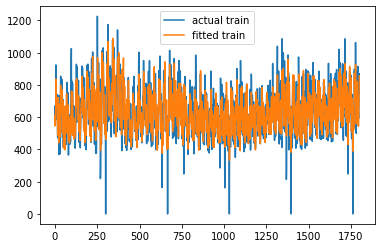

In [33]:
plt.plot(trainY, label='actual train')
plt.plot(model.predict(trainX), label='fitted train')
plt.legend()

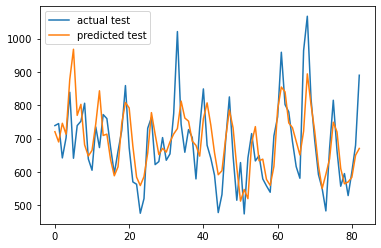

In [34]:
plt.plot(testY, label = 'actual test')
plt.plot(y_test_pred, label='predicted test')
plt.legend()

In [35]:
df_ca_s3_foods_3 = df_sales[(df_sales['cat_id']=='FOODS')
                         &(df_sales['dept_id']=='FOODS_3')
                         &(df_sales['store_id']=='CA_3')]
s3_foods_3 = df_ca_s3_foods_3.groupby('dept_id').sum().T.reset_index()

s3_foods_3.rename({'index':'d'},axis=1,inplace=True)

df_calender.fillna('nothing',axis=1,inplace=True)

s3_foods_3_fm = s3_foods_3.merge(df_calender, on='d').drop(['snap_TX','snap_WI','wday','d'],axis=1)

s3_foods_3_fm['event_1'] = s3_foods_3_fm['event_name_1']+s3_foods_3_fm['event_type_1']
s3_foods_3_fm['event_2'] = s3_foods_3_fm['event_name_2']+s3_foods_3_fm['event_type_2']

s3_foods_3_fm.drop(['event_name_1','event_type_1','event_name_2','event_type_2','wm_yr_wk'],axis=1,inplace=True)

s3_foods_3_fm = pd.concat([s3_foods_3_fm,pd.get_dummies(s3_foods_3_fm[['weekday','month','event_1','event_2']],drop_first=True)],axis=1)

s3_foods_3_fm.drop(['weekday','month','event_1','event_2','year'],axis=1,inplace=True)

s3_foods_3_fm.set_index('date',inplace=True)

trainX=[]
trainY=[]
n_future=1
n_past = 30
for i in range(n_past,len(s3_foods_3_fm)-n_future+1):
    trainX.append(s3_foods_3_fm.iloc[i-n_past:i,0:s3_foods_3_fm.shape[1]])
    trainY.append(s3_foods_3_fm.iloc[i+n_future-1:i+n_future,0])

trainX = np.array(trainX)
trainY = np.array(trainY)

testX = [i for i in trainX[1800:]]
testY = [i for i in trainY[1800:]]

testX = np.array(testX)
testY = np.array(testY)

trainX = trainX[:1800]
trainY = trainY[:1800]

In [37]:
input_shape=(trainX.shape[1],trainX.shape[2])
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu',input_shape=input_shape,
               return_sequences=True))
model.add(LSTM(32, activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam',loss='mse')
filepath="multi_LSTM_ca3_foods_3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',patience=50)
history = model.fit(trainX, trainY, epochs=500,batch_size=20,verbose=1,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/500
72/72 [==============================] - ETA: 0s - loss: 4611239.0000
Epoch 1: val_loss improved from inf to 2700610.25000, saving model to multi_LSTM_ca3_foods_3.hdf5
72/72 [==============================] - 5s 28ms/step - loss: 4611239.0000 - val_loss: 2700610.2500
Epoch 2/500
70/72 [============================>.] - ETA: 0s - loss: 2935872.2500
Epoch 2: val_loss improved from 2700610.25000 to 1877219.37500, saving model to multi_LSTM_ca3_foods_3.hdf5
72/72 [==============================] - 2s 22ms/step - loss: 2940562.2500 - val_loss: 1877219.3750
Epoch 3/500
70/72 [============================>.] - ETA: 0s - loss: 4693430.0000
Epoch 3: val_loss did not improve from 1877219.37500
72/72 [==============================] - 1s 21ms/step - loss: 4721684.5000 - val_loss: 5593311.5000
Epoch 4/500
70/72 [============================>.] - ETA: 0s - loss: 8010055.5000
Epoch 4: val_loss did not improve from 1877219.37500
72/72 [==============================] - 1s 20ms/step - loss

In [38]:
model.load_weights("multi_LSTM_ca3_foods_3.hdf5")
model.compile(optimizer='adam', loss='mse')
y_test_pred= model.predict(testX)
mape(testY, y_test_pred)

3/3 [==============================] - 0s 10ms/step


0.08429625957020474

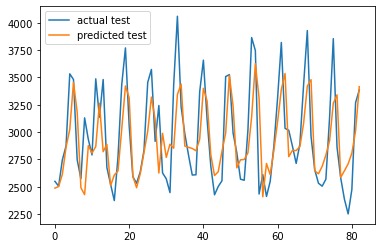

In [39]:
plt.plot(testY, label = 'actual test')
plt.plot(y_test_pred, label='predicted test')
plt.legend()

# Notice that we got better MAPEs for many other stores using our best LSTM model

In [10]:
df_ca_s3_foods_3 = df_sales[(df_sales['cat_id']=='FOODS')
                         &(df_sales['dept_id']=='FOODS_3')
                         &(df_sales['store_id']=='CA_3')]

df_ca_s3_foods_3

item_3_001 = df_ca_s3_foods_3[df_ca_s3_foods_3['item_id']=='FOODS_3_001'].T.iloc[6:,]

item_3_001.reset_index(inplace=True)

item_3_001

item_3_001[8324].plot()

In [30]:
s3_foods_3 = df_ca_s3_foods_3.groupby('dept_id').sum().T.reset_index()

In [31]:
total_and_item = s3_foods_3.merge(item_3_001,on='index')

In [32]:
total_and_item[total_and_item[8324]==max(total_and_item[8324])]

index  FOODS_3 8324
365  d_366     3161   33

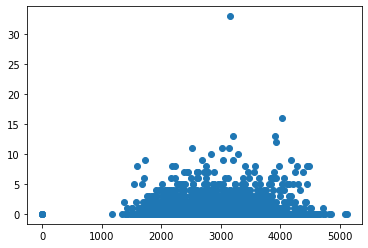

In [33]:
plt.scatter(total_and_item['FOODS_3'],total_and_item[8324])

In [34]:
df_ca_s3_foods_3

id      item_id  dept_id cat_id store_id  \
8324  FOODS_3_001_CA_3_validation  FOODS_3_001  FOODS_3  FOODS     CA_3   
8325  FOODS_3_002_CA_3_validation  FOODS_3_002  FOODS_3  FOODS     CA_3   
8326  FOODS_3_003_CA_3_validation  FOODS_3_003  FOODS_3  FOODS     CA_3   
8327  FOODS_3_004_CA_3_validation  FOODS_3_004  FOODS_3  FOODS     CA_3   
8328  FOODS_3_005_CA_3_validation  FOODS_3_005  FOODS_3  FOODS     CA_3   
...                           ...          ...      ...    ...      ...   
9142  FOODS_3_823_CA_3_validation  FOODS_3_823  FOODS_3  FOODS     CA_3   
9143  FOODS_3_824_CA_3_validation  FOODS_3_824  FOODS_3  FOODS     CA_3   
9144  FOODS_3_825_CA_3_validation  FOODS_3_825  FOODS_3  FOODS     CA_3   
9145  FOODS_3_826_CA_3_validation  FOODS_3_826  FOODS_3  FOODS     CA_3   
9146  FOODS_3_827_CA_3_validation  FOODS_3_827  FOODS_3  FOODS     CA_3   

     state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  \
8324       CA    4    1    1    0  ...       2       0       6       2   
8325       CA    0    0    0    0  ...       0       0       0       0   
8326       CA    0    0    0    0  ...       1       1       3       1   
8327       CA    0    0    0    0  ...       2       0       2       0   
8328       CA    1    3    0    1  ...       0       0       0       0   
...       ...  ...  ...  ...  ...  ...     ...     ...     ...     ...   
9142       CA   10    5    4    5  ...       2       2       2       3   
9143       CA    1    3    1    2  ...       0       3       1       0   
9144       CA    0    0    0    0  ...       3       0       4       3   
9145       CA    0    0    0    0  ...       5       2       2       0   
9146       CA    0    0    0    0  ...       6       9       2       6   

      d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
8324       0       3       4       0       0       2  
8325       0       0       0       0       0       0  
8326       2       0       0       1       1       3  
8327       0       0       0       0       0       1  
8328       0       0       0       0       0       0  
...      ...     ...     ...     ...     ...     ...  
9142       3       2       3       4       1       0  
9143       1       0       4       1       0       1  
9144       3       0       0       3       3       6  
9145       1       1       3       0       1       3  
9146       9       3       1       3       3      13  

[823 rows x 1919 columns]

In [35]:
total_and_item = pd.concat([total_and_item,df_calender[['date']]],axis=1).dropna()

In [36]:
total_and_item['month'] = total_and_item['date'].apply(lambda x: x[:7])

In [37]:
total_and_item = total_and_item.iloc[3:,]

In [38]:
total_and_item[8324] = total_and_item[8324].astype(int)

In [39]:
total_and_item_monthly = total_and_item.groupby('month').sum()

# Future work - we may be able to model monthly data of a single item

<AxesSubplot:xlabel='month'>

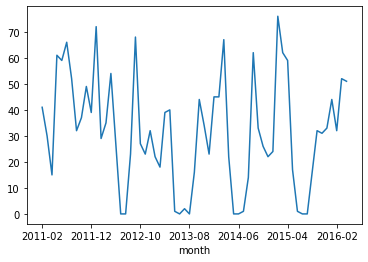

In [40]:
total_and_item_monthly[8324].plot()

# We may also be able to model percentage of a given item under a given food category

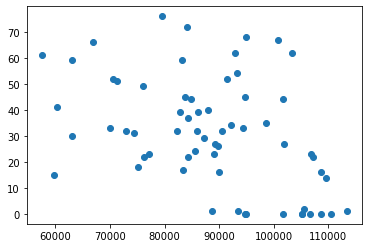

In [93]:
plt.scatter(total_and_item_monthly['FOODS_3'],total_and_item_monthly[8324])